# Аналитика и модель для увеличения покупательской активности клиентов интернет-магазина


Отчёт магазина «В один клик» за прошлый период показал, что активность покупателей начала снижаться. Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Импорт библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

!pip3 install phik
import phik

import seaborn as sns

!pip3 install shap
import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, roc_curve, plot_roc_curve, roc_auc_score



     |████████████████████████████████| 679 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 532 kB 1.0 MB/s eta 0:00:01


## Загрузка данных

In [2]:
df1 = pd.read_csv('/datasets/market_file.csv')
df2 = pd.read_csv('/datasets/market_money.csv')
df3 = pd.read_csv('/datasets/market_time.csv')
df4 = pd.read_csv('/datasets/money.csv', sep = ';', decimal=',')

In [3]:
display(df1.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
display(df2.head())

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
display(df3.head())

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
display(df4.head())

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Вывод 
Данные импортированы, датасет /datasets/money.csv содержал отличный от других разделитель столбцов и десятичных дробей. Содержимое столбиков выглядит адекватно их названиям и заявленному содержимому.

## Предобработка данных

In [7]:
display(df1.info())
print()
display(df1.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [8]:
for column in df1.columns:
    print(df1[column].unique())
    
df1 = df1.replace('стандартт', 'стандарт')

for column in df1.columns:
    print(df1[column].unique())

[215348 215349 215350 ... 216645 216646 216647]
['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
[3.4 4.4 4.9 3.2 5.1 3.3 4.7 4.2 3.9 4.6 4.3 3.8 2.7 4.8 2.9 3.  2.4 1.7
 3.6 4.  1.5 3.5 4.1 3.1 1.4 0.9 5.6 2.6 5.5 5.2 5.8 5.  5.4 5.7 5.3 3.7
 6.3 6.6 4.5 6.1 5.9]
[5 4 3]
[ 121  819  539  896 1064  762  431  284  192  154  450  110  623  199
  438  923  708  167  209  581  829  607  572  365  566  811  268  558
  534  730  488  436  637  554  330  504 1020  721  495  135  663 1047
  152  754  525  169  966  645  706  689  882 1007  304  339  954  771
  699  669  511  974  666  857 1048  756  506  759  768  720  219  377
  472  806  449  523  503  515  813  249  186  336  690  824  753  674
  875  844  602  855  448  344  922  298  893  881  372  788  937  764
  851 1021  627  748  684  719  891  842  573 1057  342  638  458  254
  600  871  574  982  324  373  839  845  475  509  252  820  744  541
 1079  900  474  957  773  717  508  184  828  944  419  

In [9]:
print('Поиск пропусков')
df1.isna().sum()

Поиск пропусков


id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [10]:
print('Полные дубликаты', df1.duplicated().sum())

df1 = df1.drop_duplicates()

print('Полные дубликаты после удаления', df1.duplicated().sum())

Полные дубликаты 0
Полные дубликаты после удаления 0


In [11]:
display(df2.info())
print()
display(df2.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [12]:
for column in df2.columns:
    print(df2[column].unique())

[215348 215349 215350 ... 216645 216646 216647]
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
[   0.  3293.1 4472.  ... 5224.6 4720.  4448.3]


In [13]:
print('Поиск пропусков')
df2.isna().sum()

Поиск пропусков


id         0
Период     0
Выручка    0
dtype: int64

In [14]:
print('Полные дубликаты', df2.duplicated().sum())

df2 = df2.drop_duplicates()

print('Полные дубликаты после удаления', df2.duplicated().sum())

Полные дубликаты 0
Полные дубликаты после удаления 0


In [15]:
display(df3.info())
print()
display(df3.describe())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [16]:

for column in df3.columns:
    print(df3[column].unique())
    
df3 = df3.replace('предыдцщий_месяц', 'предыдущий_месяц')

for column in df3.columns:
    print(df3[column].unique())

[215348 215349 215350 ... 216645 216646 216647]
['текущий_месяц' 'предыдцщий_месяц']
[14 13 10 12  8 11  6  7  9  5 15  4 16 17 19 18 22 20 21 23]
[215348 215349 215350 ... 216645 216646 216647]
['текущий_месяц' 'предыдущий_месяц']
[14 13 10 12  8 11  6  7  9  5 15  4 16 17 19 18 22 20 21 23]


In [17]:
print('Поиск пропусков')
df3.isna().sum()

Поиск пропусков


id        0
Период    0
минут     0
dtype: int64

In [18]:
print('Полные дубликаты', df3.duplicated().sum())

df3 = df3.drop_duplicates()

print('Полные дубликаты после удаления', df3.duplicated().sum())

Полные дубликаты 0
Полные дубликаты после удаления 0


In [19]:
display(df4.info())
print()
display(df4.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


In [20]:
for column in df4.columns:
    print(df4[column].unique())

[215348 215349 215350 ... 216645 216646 216647]
[0.98 4.16 3.13 4.87 4.21 3.95 3.62 5.26 4.93 4.66 3.06 5.08 4.55 4.03
 3.49 1.83 2.67 3.65 2.95 3.03 6.27 3.86 2.82 1.4  1.63 3.69 4.08 4.18
 4.26 4.27 4.42 3.88 2.42 4.78 4.85 4.05 3.48 5.16 4.6  5.7  5.44 4.1
 2.93 3.9  3.28 5.09 3.19 4.77 5.01 6.73 7.43 4.28 3.73 3.38 3.47 5.
 2.02 3.68 2.68 4.46 2.41 5.4  3.4  4.22 4.5  4.98 3.96 3.18 4.65 3.92
 3.89 5.64 2.76 4.25 3.71 4.63 2.97 3.24 3.81 4.04 6.33 4.68 3.6  3.04
 4.41 3.98 2.47 4.52 4.01 5.31 2.53 5.83 4.48 2.98 4.92 3.08 4.9  3.94
 2.99 4.62 3.76 3.42 4.17 4.47 4.69 4.59 2.84 3.66 4.97 2.19 2.74 5.41
 4.12 3.93 5.02 3.52 3.39 6.12 4.64 3.14 4.71 4.99 3.74 4.   5.23 2.08
 6.55 2.36 4.32 3.15 2.77 5.56 3.44 3.58 2.92 4.67 3.33 2.94 1.06 2.45
 4.86 5.05 3.2  2.8  4.13 1.81 2.79 4.11 2.55 3.84 3.17 4.51 3.45 3.27
 4.2  4.33 3.01 5.79 3.12 6.59 6.88 2.7  2.69 5.49 2.34 5.25 3.25 4.74
 3.77 4.34 5.06 4.95 3.1  4.14 3.3  3.99 2.6  4.31 2.96 4.19 5.12 5.35
 4.29 4.61 2.29 4.43 5.99 5.04 3

In [21]:
print('Поиск пропусков')
df4.isna().sum()

Поиск пропусков


id         0
Прибыль    0
dtype: int64

In [22]:
print('Полные дубликаты', df4.duplicated().sum())

df4 = df4.drop_duplicates()

print('Полные дубликаты после удаления', df4.duplicated().sum())

Полные дубликаты 0
Полные дубликаты после удаления 0


### Вывод
Устранены опечатки и удалены явные дубликаты. Пропусков не обнаружено.

## Исследовательский анализ данных

In [23]:
# Функция построения корреляционной матрицы данных. На входе датасет, функция строит heatmap матрицы корреляции.
def corr_max(df):
    plt.figure(figsize = (16,6))
    corr = df.drop('id', axis = 1).corr()
    sns.heatmap(corr, cmap="Blues", annot=True)
    return

# Функция визуализации данных типа object. На входе датасет, функция строит hist и pieplot для object столбцов.
def barplotter(df):
    df = df.drop('id', axis = 1).copy()
    for column in df.select_dtypes(include=[object]).columns:
        print(column, 'анализ')
        display(df[column].describe())
        plt.figure(figsize=(16, 4))
        plt.hist(df[column], align='mid', bins = len(df[column].unique()))
        #plt.bar(df[column], align='mid', bins = len(df[column].unique()))
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
        print()
        plt.figure(figsize=(16, 4))
        df[column].value_counts(dropna=False).plot(kind="pie", autopct='%1.0f%%', figsize=(11, 6))
        plt.title(column)
        plt.show()
        
        
    return

# Функция виуализации численных данных. На входе датасет, функция строит hist и boxplot для численных столбцов.
def histplotter(df):
    df = df.drop('id', axis = 1).copy()
    for column in df.select_dtypes(exclude=[object]).columns:
        print(column, 'анализ')
        display(df[column].describe())
        plt.figure(figsize=(16, 5))
        plt.hist(df[column], align='mid', bins = np.min([len(df[column].unique()), 20]))
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
        print()
        plt.figure(figsize=(16, 5))
        plt.boxplot(df[column])
        plt.xlabel(column)
        plt.show()
    return

"\n#функция построения гистограмм численных данных\ndef boxplotter(df):\n    df = df.drop('id', axis = 1).copy()\n    for column in df.select_dtypes(exclude=[object]).columns:\n        print(column, 'анализ')\n        display(df[column].describe())\n        plt.figure(figsize=(16, 5))\n        plt.boxplot(df[column])\n        plt.xlabel(column)\n        #plt.ylabel('Frequency')\n        #plt.title('hist')\n        plt.show()\n        print()\n    return\n\n"

### Анализ df1

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']


<module 'seaborn' from '/opt/conda/lib/python3.9/site-packages/seaborn/__init__.py'>

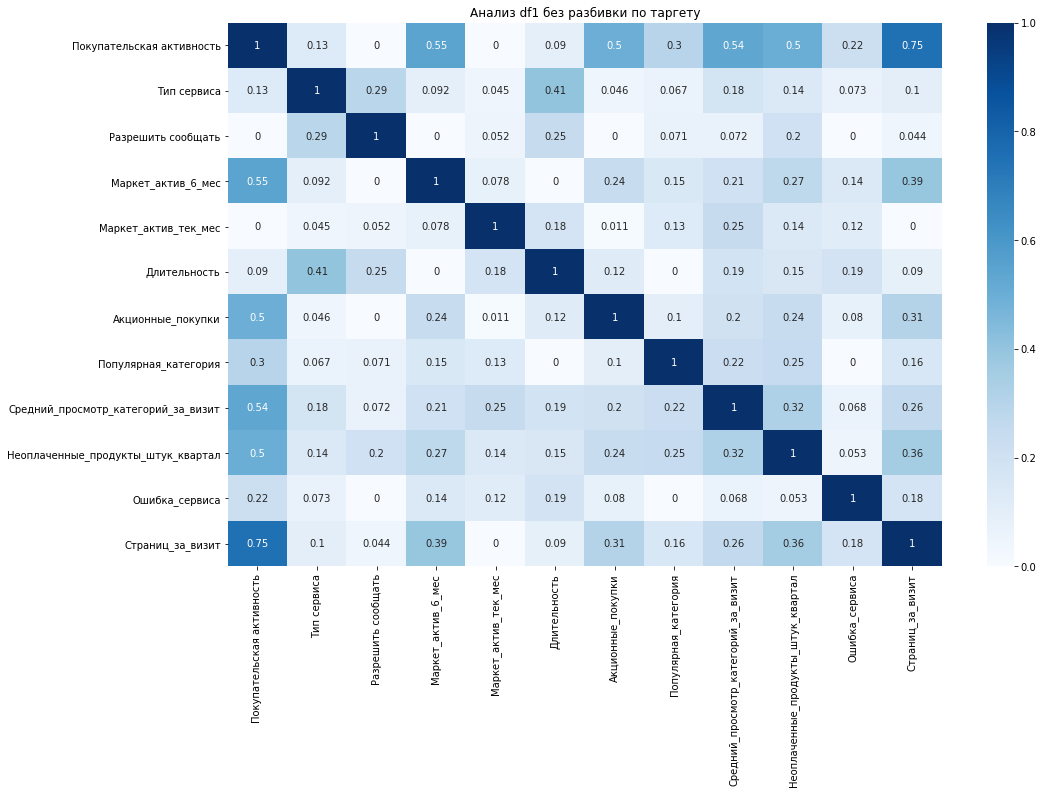

In [24]:
plt.figure(figsize = (16,10))
plt.title('Анализ df1 без разбивки по таргету')
corr = df1.drop('id', axis = 1).phik_matrix()
sns.heatmap(corr, cmap="Blues", annot=True)
sns

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']


Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column


<module 'seaborn' from '/opt/conda/lib/python3.9/site-packages/seaborn/__init__.py'>

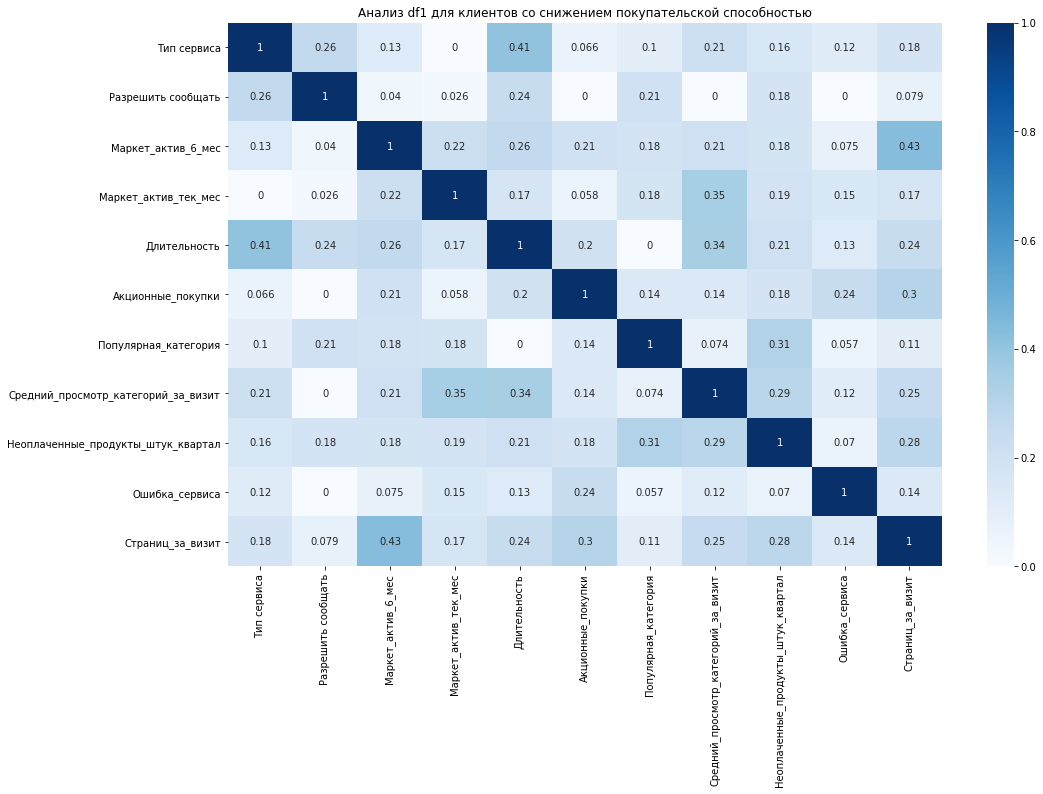

In [25]:
plt.figure(figsize = (16,10))
plt.title('Анализ df1 для клиентов со снижением покупательской способностью')
corr = df1[df1['Покупательская активность'] == 'Снизилась'].drop('id', axis = 1).phik_matrix()
sns.heatmap(corr, cmap="Blues", annot=True)
sns

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']


Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column


<module 'seaborn' from '/opt/conda/lib/python3.9/site-packages/seaborn/__init__.py'>

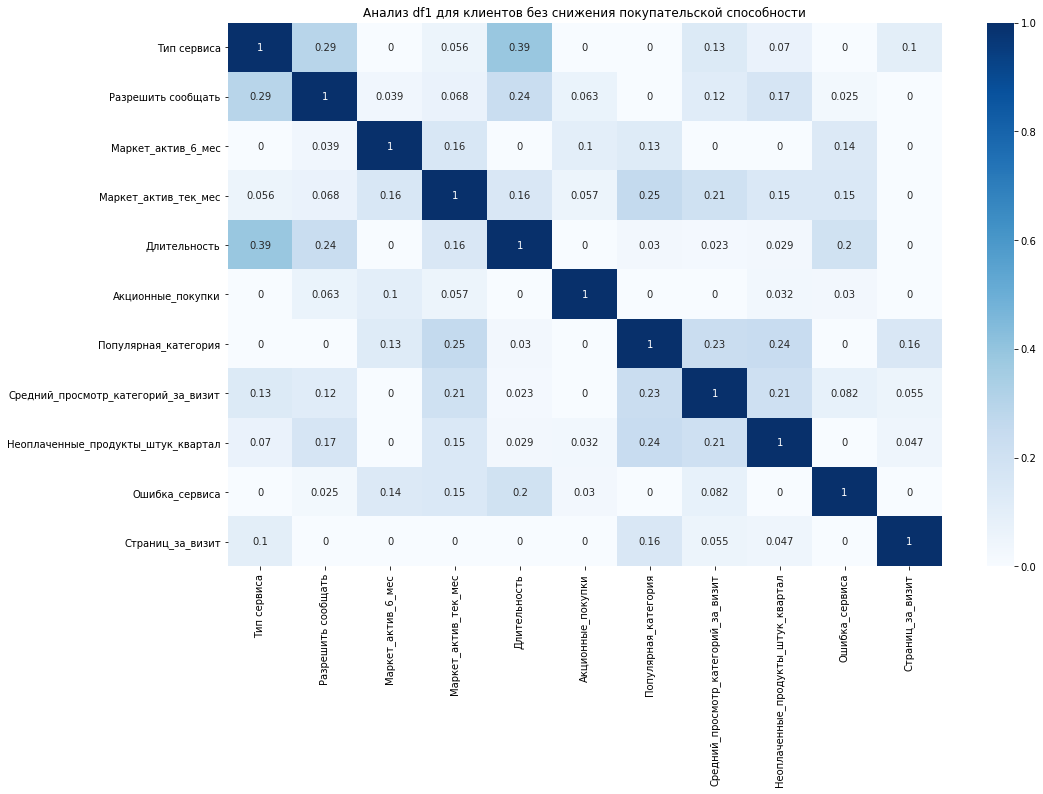

In [26]:
plt.figure(figsize = (16,10))
plt.title('Анализ df1 для клиентов без снижения покупательской способности')
corr = df1[df1['Покупательская активность'] != 'Снизилась'].drop('id', axis = 1).phik_matrix()
sns.heatmap(corr, cmap="Blues", annot=True)
sns

Построено 3 матрицы корреляции при помощи библиотеки phik(): для полного датасета df1, для клиентов df1 со снижением покупательской активности и для клиентов df1 без снижения покупательской активности. Обнаружена высокая корреляция (коэффициент 0.75) между количеством посещенных страниц за визит и снижением покупательской активности, но корреляции выше 0.9 обнаружено не было.

Столбчатые диаграммы и pie диаграммы для клиентов со сниженной покупательской активностью

Тип сервиса анализ


count          498
unique           2
top       стандарт
freq           328
Name: Тип сервиса, dtype: object

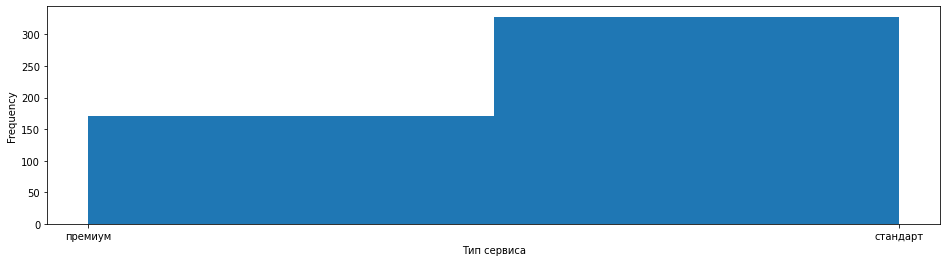

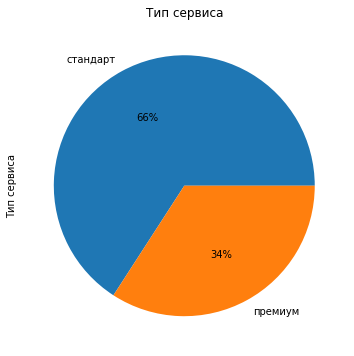

Разрешить сообщать анализ


count     498
unique      2
top        да
freq      371
Name: Разрешить сообщать, dtype: object

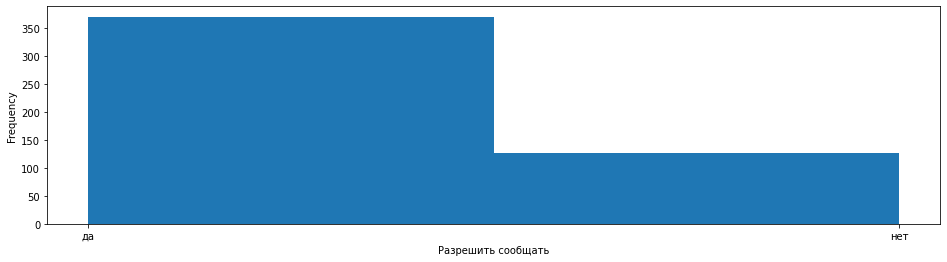

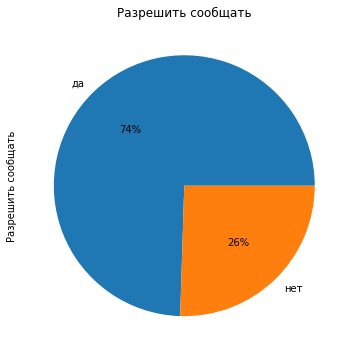

Популярная_категория анализ


count                  498
unique                   6
top       Товары для детей
freq                   146
Name: Популярная_категория, dtype: object

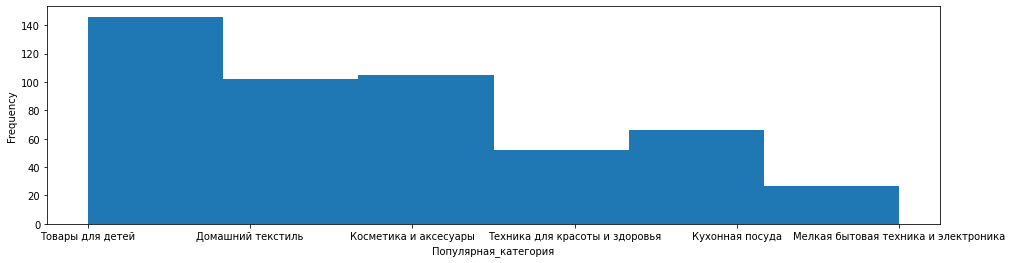

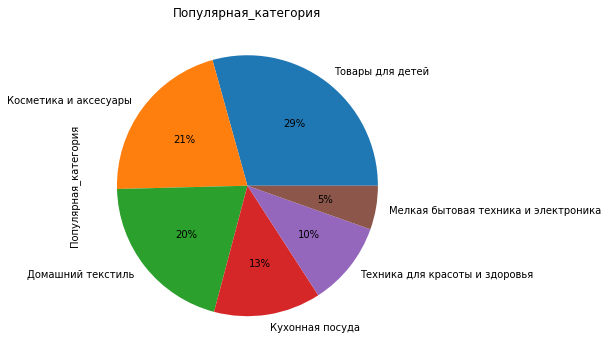


Гистограммы и Box диаграммы для клиентов со сниженной покупательской активностью

Маркет_актив_6_мес анализ


count    498.000000
mean       3.744378
std        1.053374
min        0.900000
25%        3.100000
50%        3.900000
75%        4.400000
max        6.600000
Name: Маркет_актив_6_мес, dtype: float64

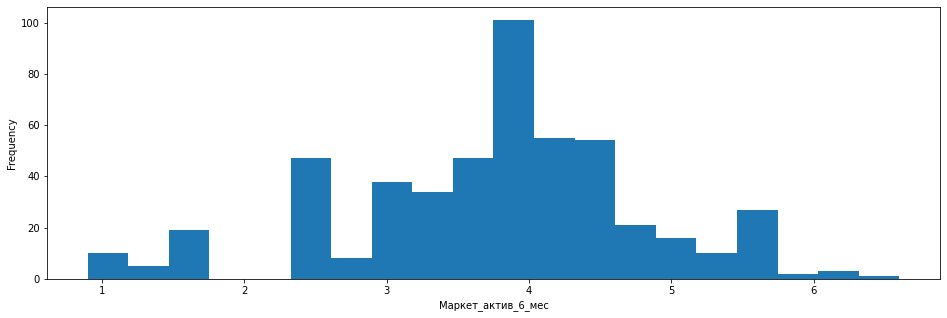

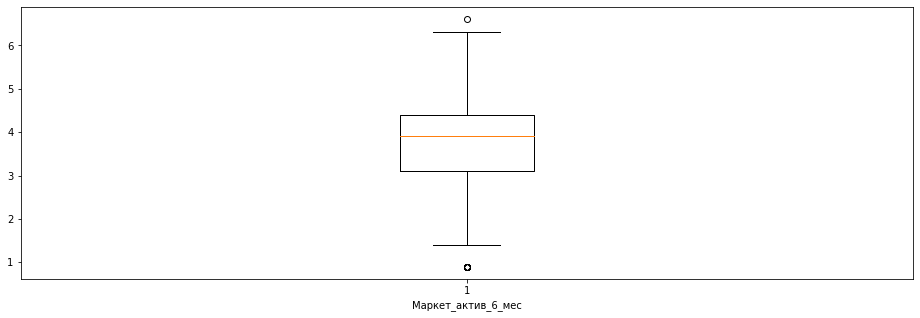

Маркет_актив_тек_мес анализ


count    498.000000
mean       4.012048
std        0.709135
min        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: Маркет_актив_тек_мес, dtype: float64

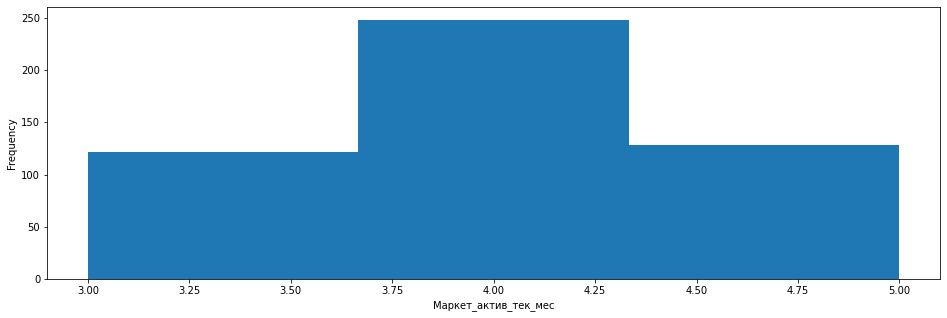

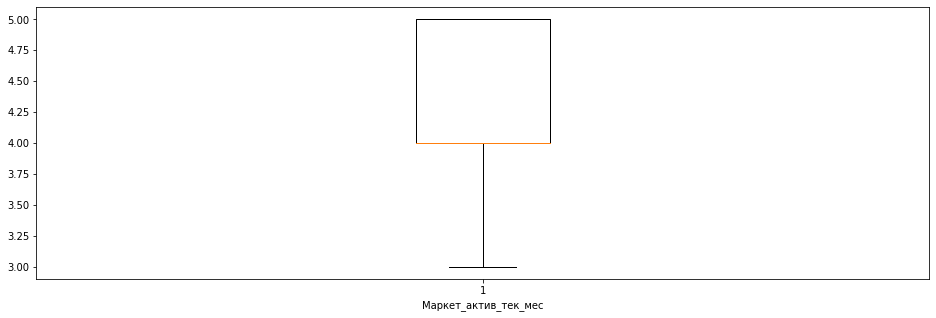

Длительность анализ


count     498.000000
mean      619.883534
std       239.940818
min       110.000000
25%       449.000000
50%       634.500000
75%       811.000000
max      1079.000000
Name: Длительность, dtype: float64

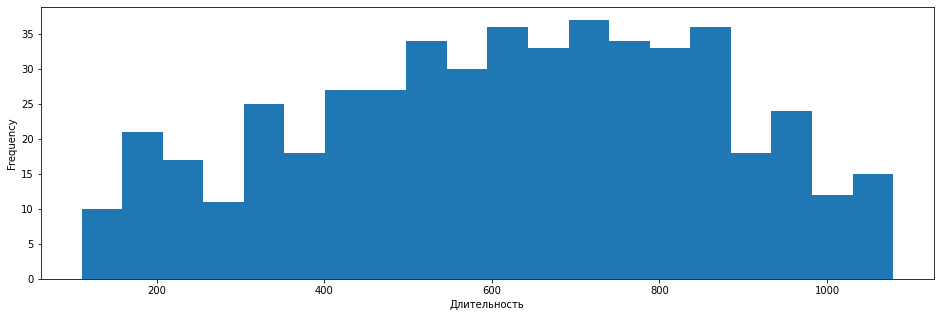

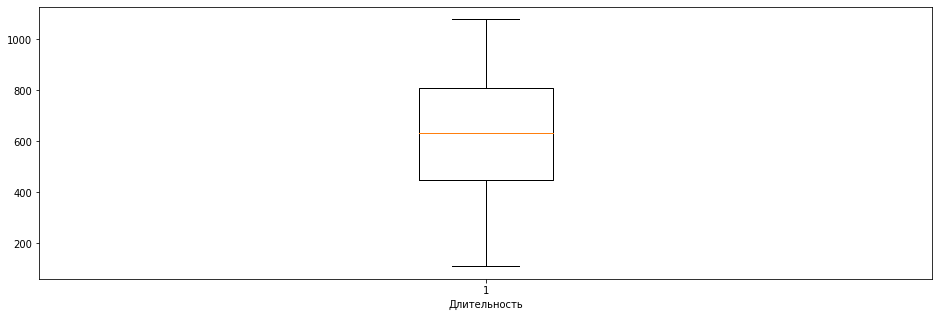

Акционные_покупки анализ


count    498.000000
mean       0.450964
std        0.306011
min        0.000000
25%        0.240000
50%        0.310000
75%        0.890000
max        0.990000
Name: Акционные_покупки, dtype: float64

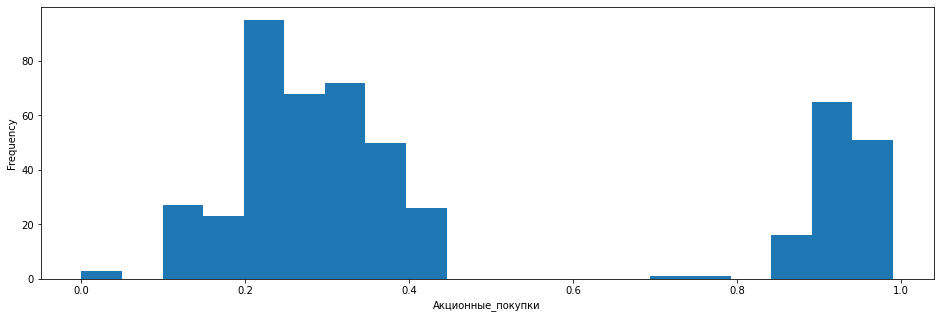

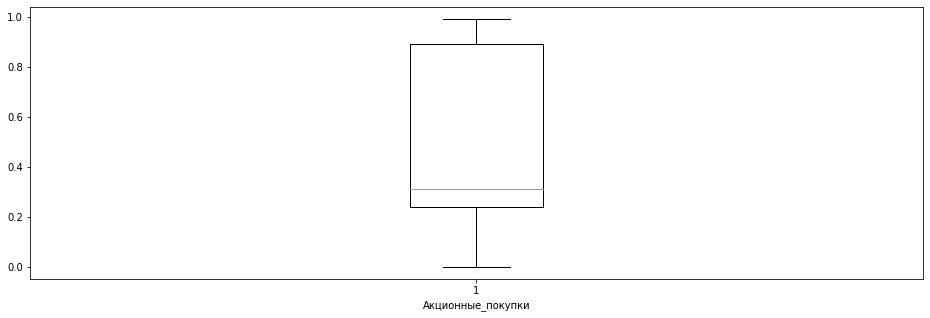

Средний_просмотр_категорий_за_визит анализ


count    498.000000
mean       2.632530
std        1.229871
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        6.000000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

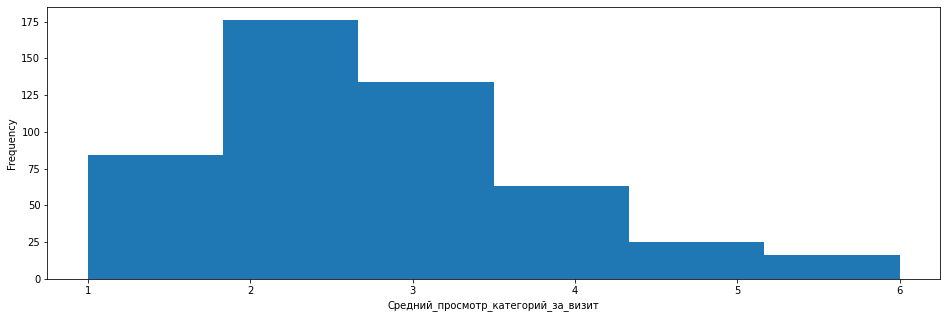

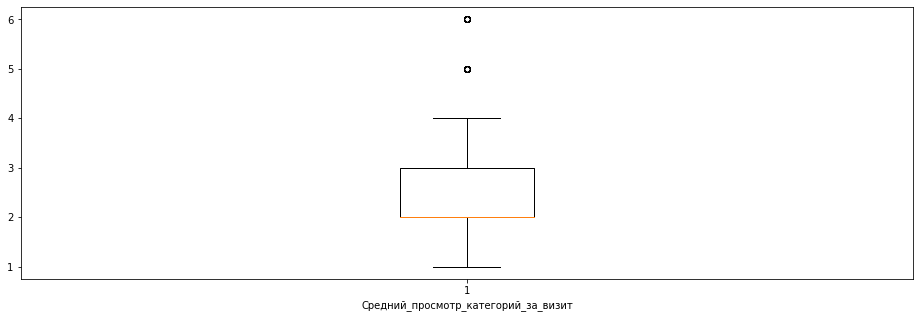

Неоплаченные_продукты_штук_квартал анализ


count    498.000000
mean       3.720884
std        2.287312
min        0.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

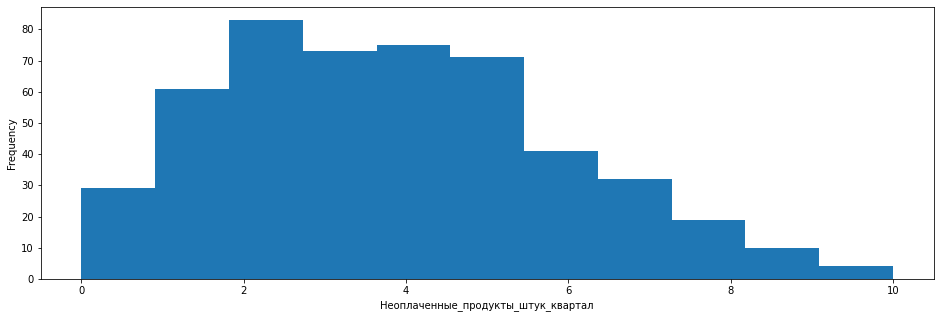

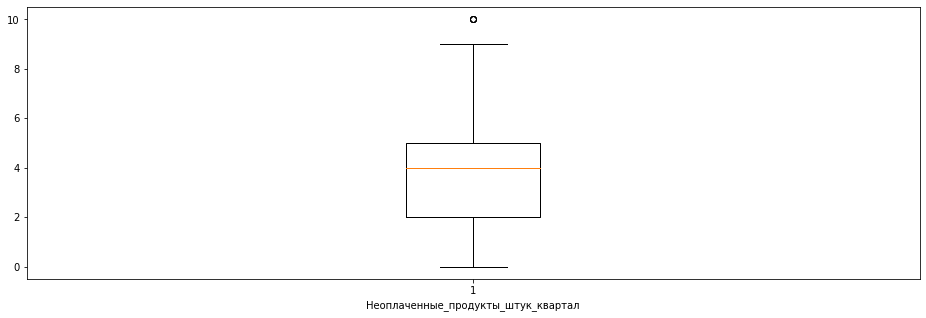

Ошибка_сервиса анализ


count    498.000000
mean       3.943775
std        1.892709
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: Ошибка_сервиса, dtype: float64

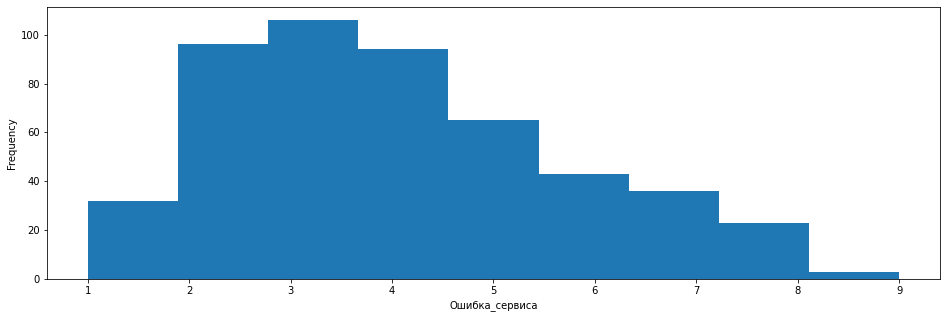

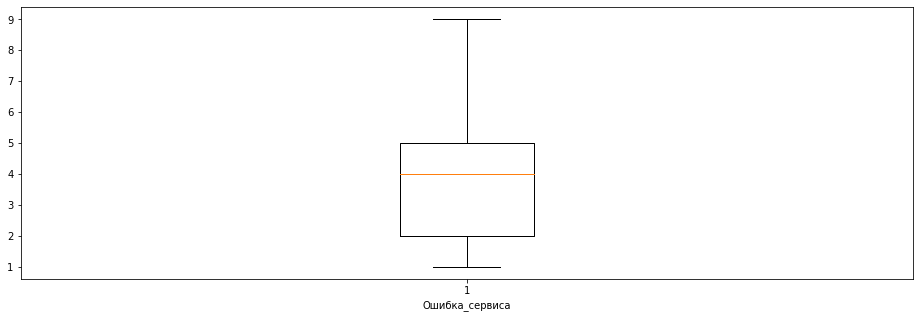

Страниц_за_визит анализ


count    498.000000
mean       5.568273
std        3.454265
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       18.000000
Name: Страниц_за_визит, dtype: float64

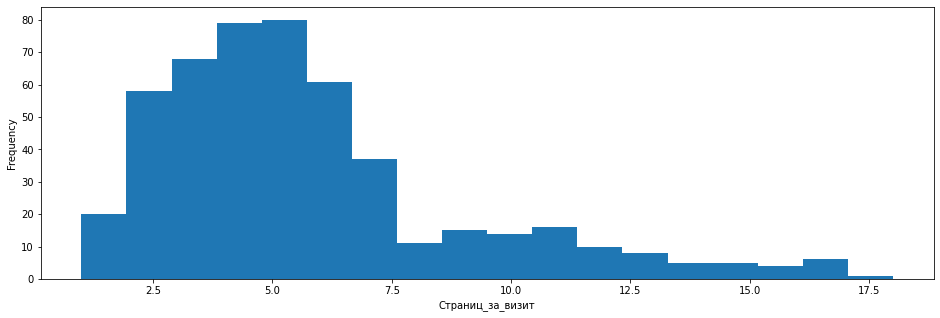

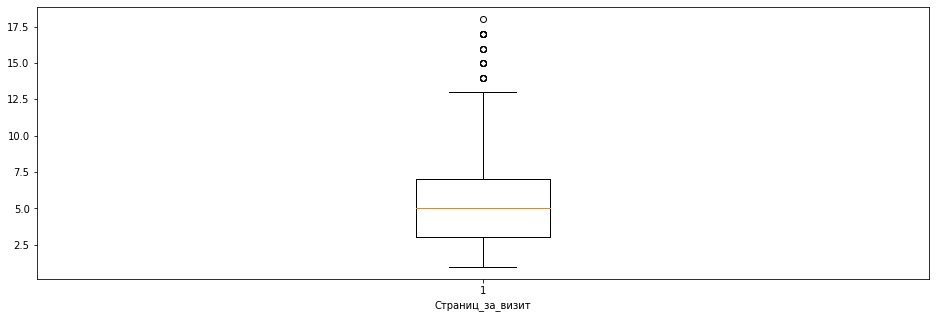

In [27]:
# barplotter(df1)

print('Столбчатые диаграммы и pie диаграммы для клиентов со сниженной покупательской активностью')
print()
barplotter(df1[df1['Покупательская активность'] == 'Снизилась'].drop('Покупательская активность', axis = 1))
print()

print('Гистограммы и Box диаграммы для клиентов со сниженной покупательской активностью')
print()
histplotter(df1[df1['Покупательская активность'] == 'Снизилась'].drop('Покупательская активность', axis = 1))
print()


Столбчатые диаграммы и pie диаграммы для клиентов с несниженной покупательской активностью

Тип сервиса анализ


count          802
unique           2
top       стандарт
freq           596
Name: Тип сервиса, dtype: object

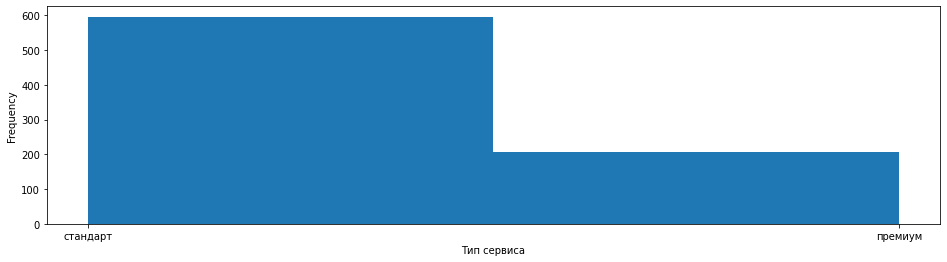

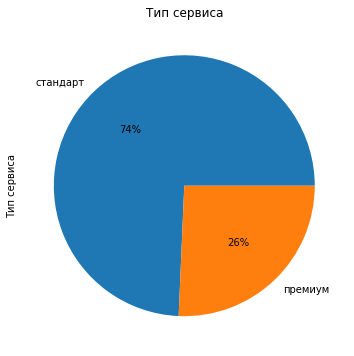

Разрешить сообщать анализ


count     802
unique      2
top        да
freq      591
Name: Разрешить сообщать, dtype: object

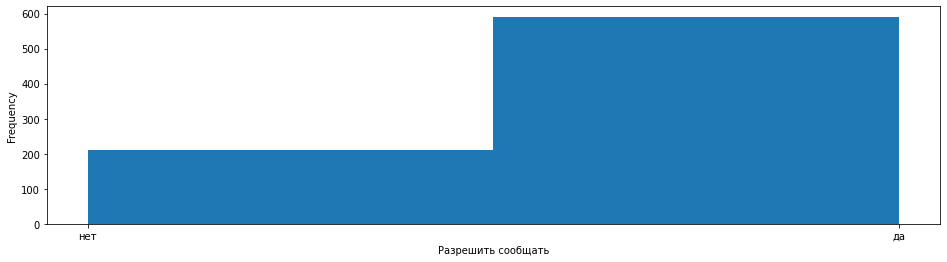

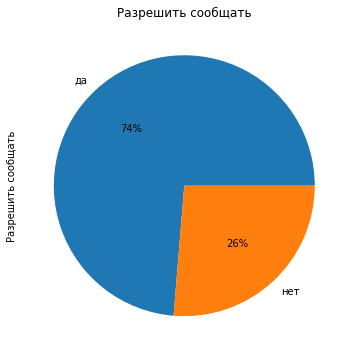

Популярная_категория анализ


count                  802
unique                   6
top       Товары для детей
freq                   184
Name: Популярная_категория, dtype: object

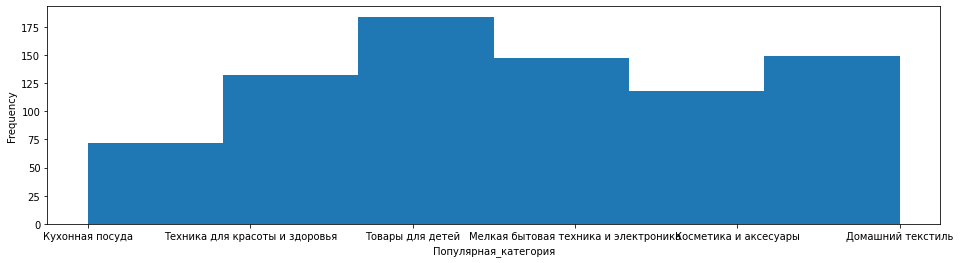

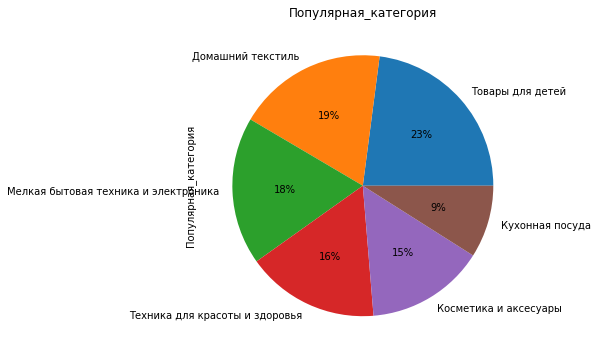


Гистограммы и Box диаграммы для клиентов с несниженной покупательской активностью

Маркет_актив_6_мес анализ


count    802.000000
mean       4.570075
std        0.848618
min        0.900000
25%        4.000000
50%        4.400000
75%        5.275000
max        6.600000
Name: Маркет_актив_6_мес, dtype: float64

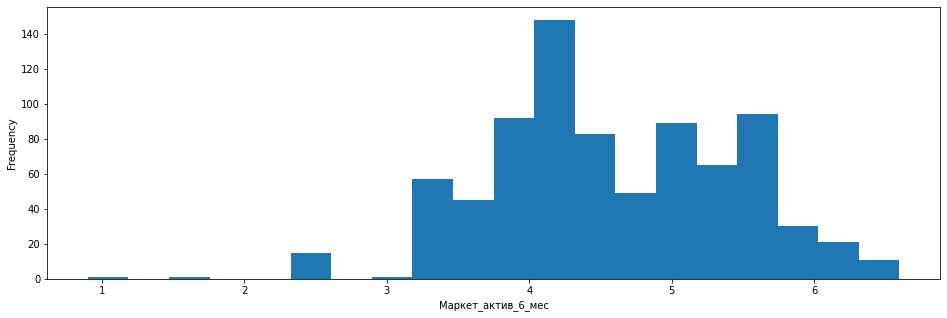

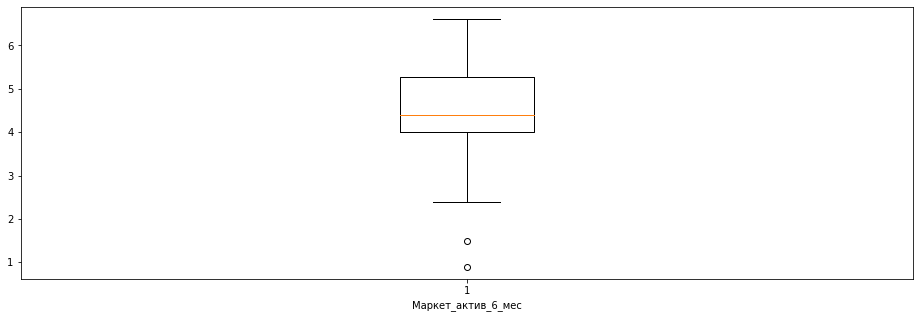

Маркет_актив_тек_мес анализ


count    802.000000
mean       4.011222
std        0.689586
min        3.000000
25%        4.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: Маркет_актив_тек_мес, dtype: float64

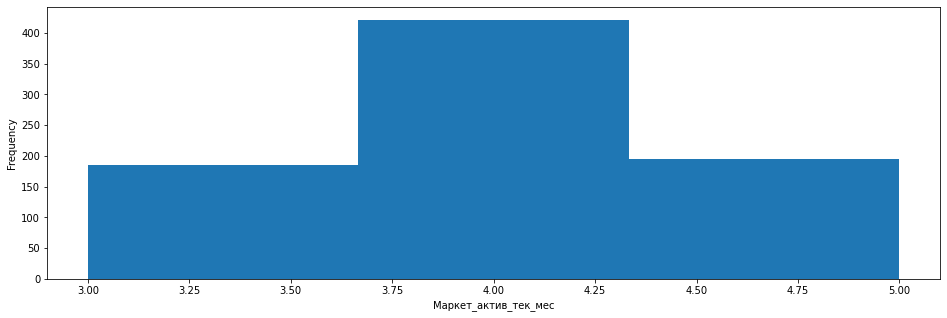

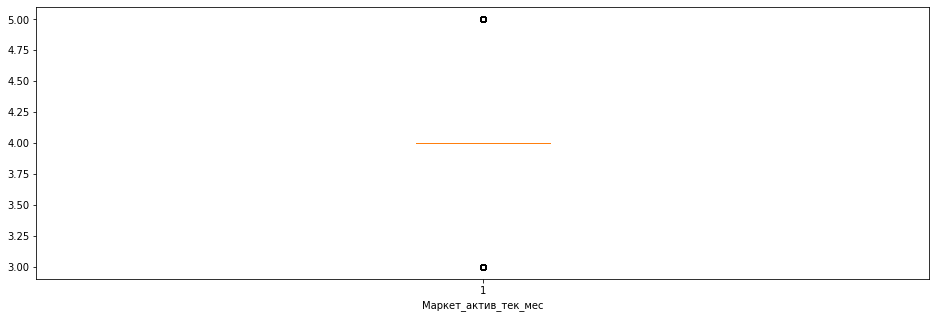

Длительность анализ


count     802.000000
mean      590.730673
std       255.330179
min       121.000000
25%       382.500000
50%       590.000000
75%       798.750000
max      1061.000000
Name: Длительность, dtype: float64

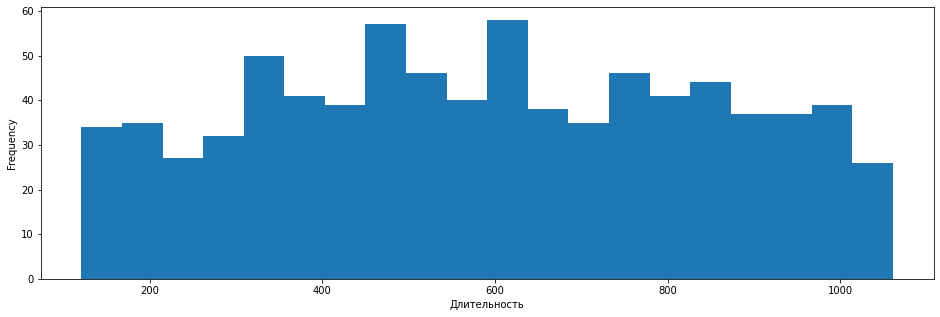

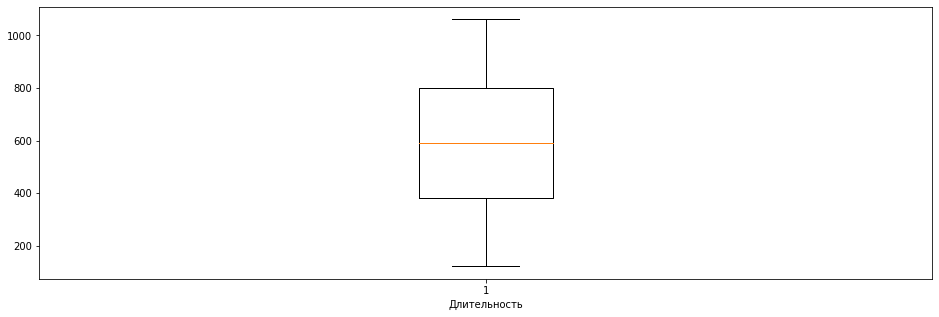

Акционные_покупки анализ


count    802.000000
mean       0.238367
std        0.160599
min        0.110000
25%        0.150000
50%        0.210000
75%        0.260000
max        0.990000
Name: Акционные_покупки, dtype: float64

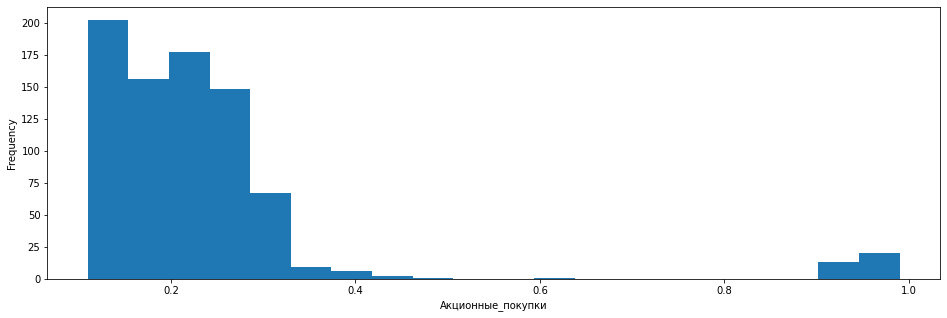

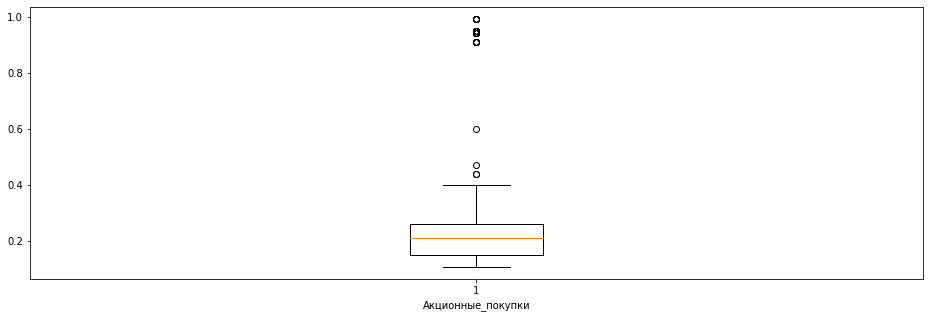

Средний_просмотр_категорий_за_визит анализ


count    802.000000
mean       3.665835
std        1.277112
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

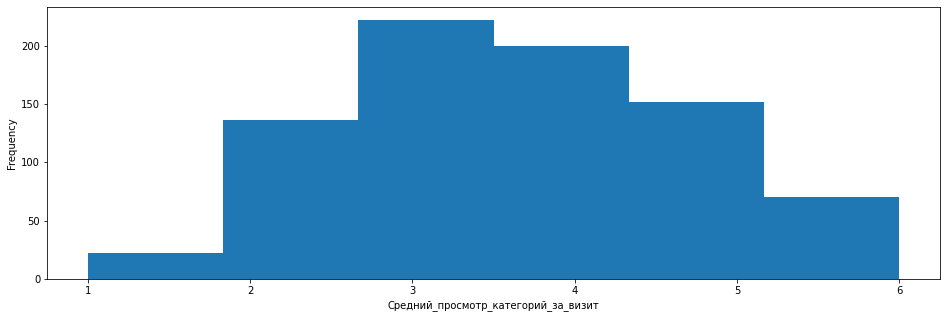

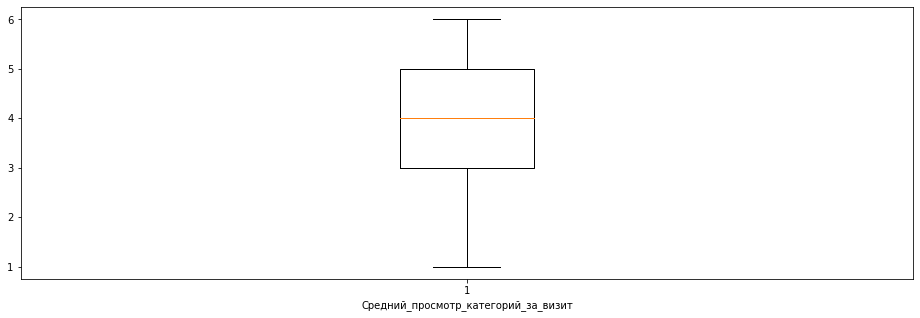

Неоплаченные_продукты_штук_квартал анализ


count    802.000000
mean       2.293017
std        1.508255
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

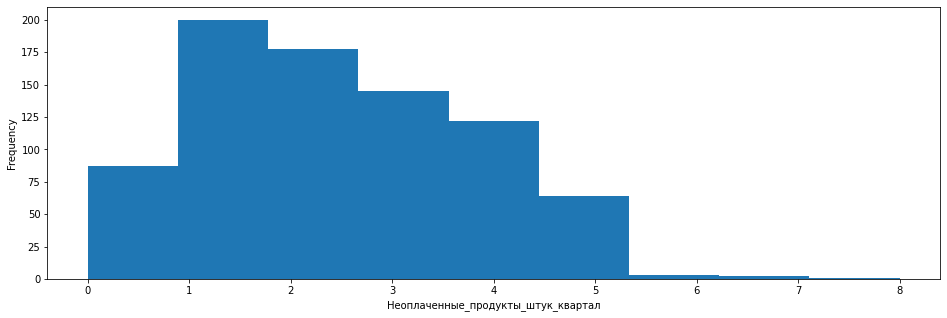

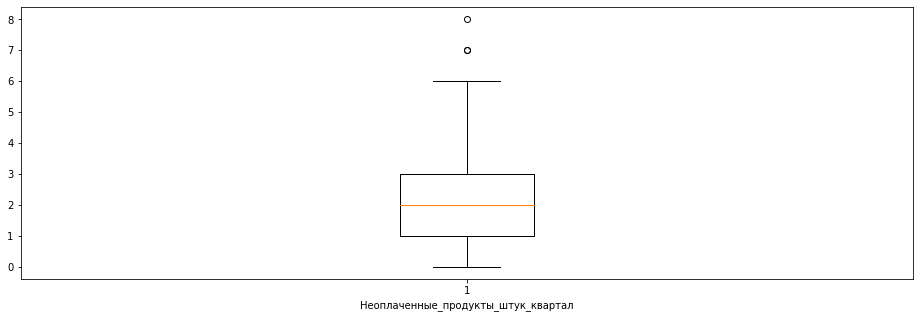

Ошибка_сервиса анализ


count    802.000000
mean       4.335411
std        1.979538
min        0.000000
25%        3.000000
50%        4.000000
75%        6.000000
max        9.000000
Name: Ошибка_сервиса, dtype: float64

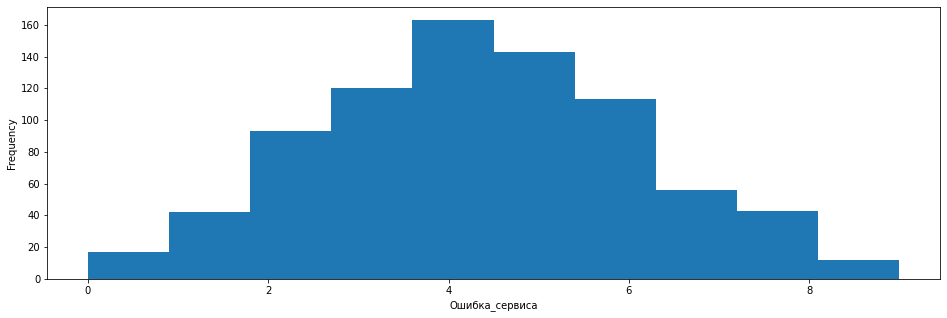

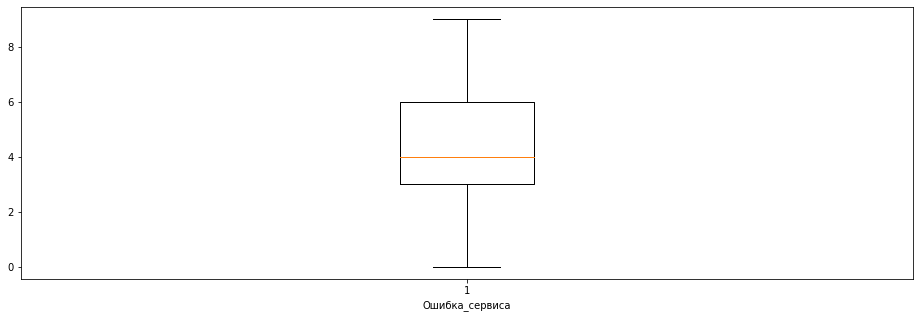

Страниц_за_визит анализ


count    802.000000
mean       9.796758
std        3.376846
min        3.000000
25%        7.000000
50%       10.000000
75%       12.000000
max       20.000000
Name: Страниц_за_визит, dtype: float64

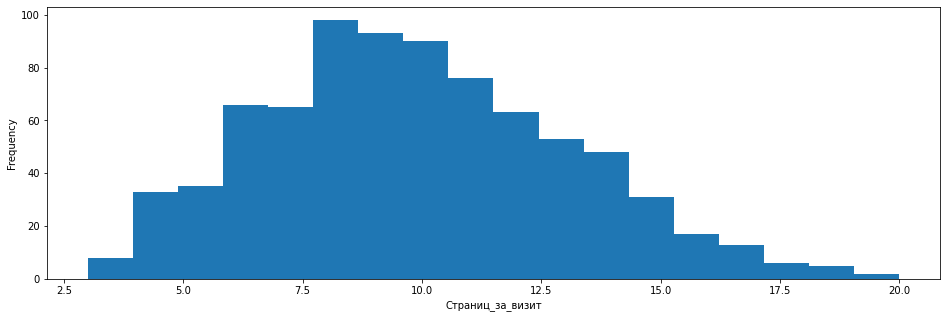

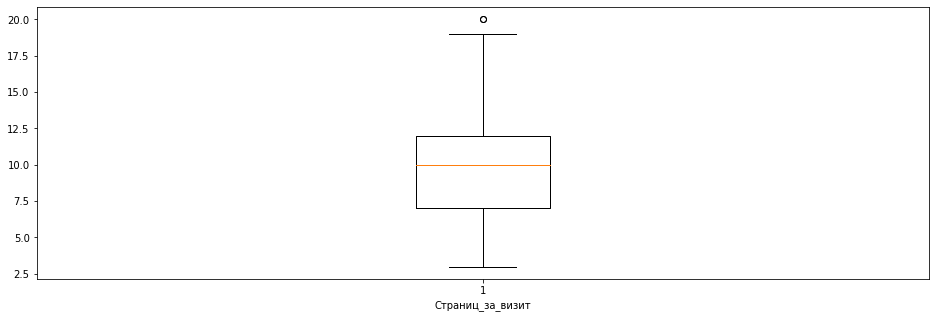

In [28]:
print('Столбчатые диаграммы и pie диаграммы для клиентов с несниженной покупательской активностью')
print()
barplotter(df1[df1['Покупательская активность'] != 'Снизилась'].drop('Покупательская активность', axis = 1))
print()

print('Гистограммы и Box диаграммы для клиентов с несниженной покупательской активностью')
print()
histplotter(df1[df1['Покупательская активность'] != 'Снизилась'].drop('Покупательская активность', axis = 1))
print()



### Выводы по df1
Аномалий в данных не обнаружено. Каждый из параметров имеет разный характер распределения: присутствуют нормальные распределения, бимодальные и несимметричные распределения. В акционных покупках мы видим бимодальное распределени - есть одна группа пользователей, которая активно использует акции (до 30% от общего числа покупок), и есть вторая группа пользователей, которая использует только акционные покупки (от 90%).

### Анализ df2

Период анализ


count              3900
unique                3
top       текущий_месяц
freq               1300
Name: Период, dtype: object

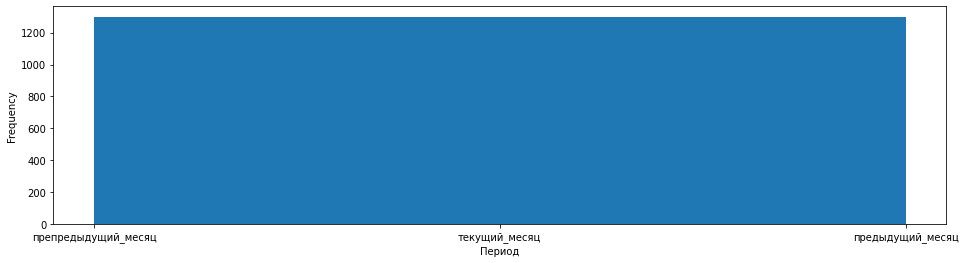

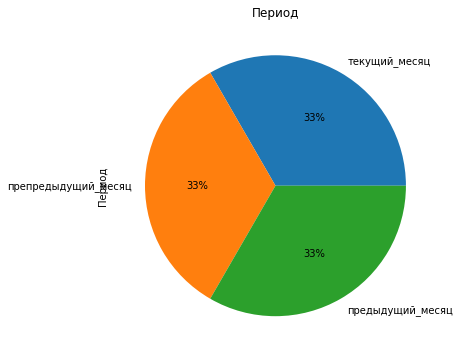

In [29]:
barplotter(df2)

Выручка анализ


count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

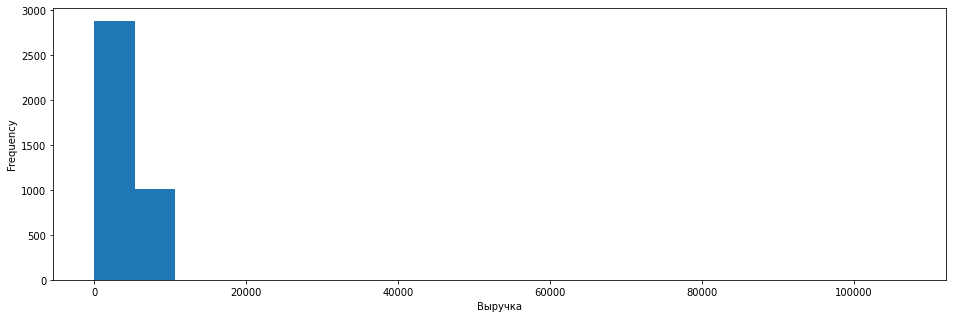

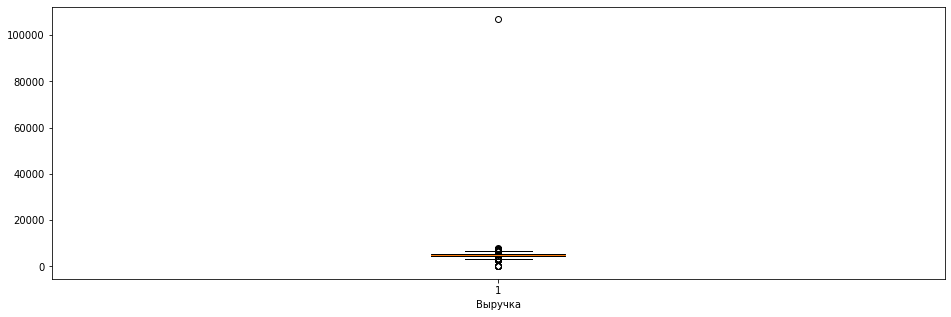

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


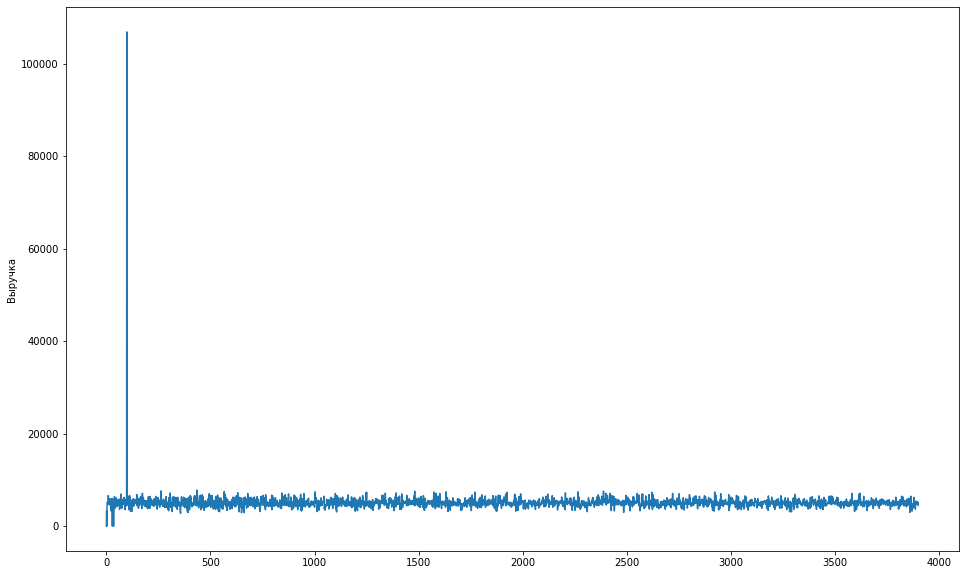

In [30]:
histplotter(df2)

plt.figure(figsize=(16, 10))
plt.plot(df2['Выручка'])
plt.ylabel('Выручка')

display(df2[df2['Выручка']>100000])

Text(0, 0.5, 'Выручка')

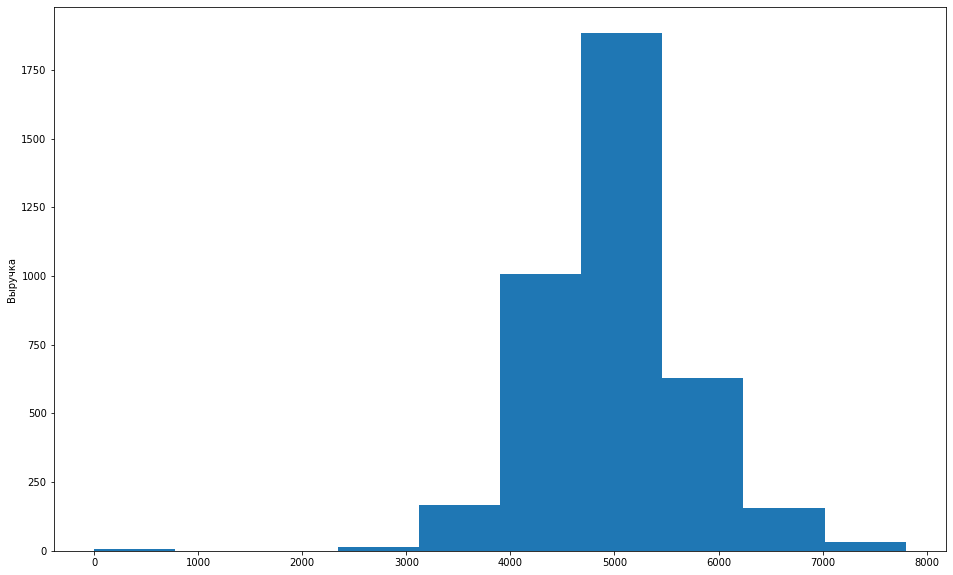

In [31]:
df2 = df2[df2['id'] != 215380]

plt.figure(figsize=(16, 10))
plt.hist(df2['Выручка'])
plt.ylabel('Выручка')

### Выводы по df2
Клиент id 215380 имеет выручку многократно превышающюю остальную статистику. Это значение похоже на промах и было удалено. Так же есть клиенты с нулевой выручкой в некоторые из месяцев. 

### Анализ df3

Период анализ


count              2600
unique                2
top       текущий_месяц
freq               1300
Name: Период, dtype: object

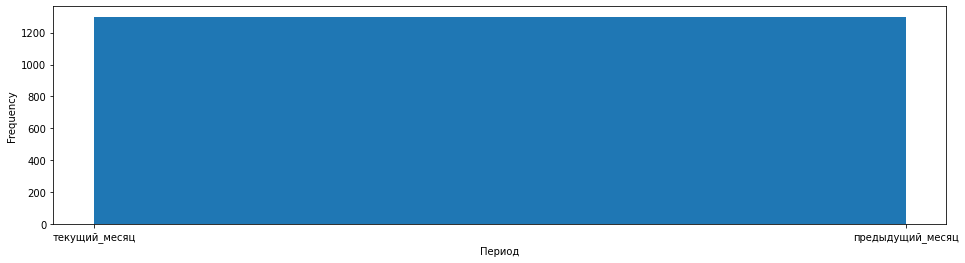

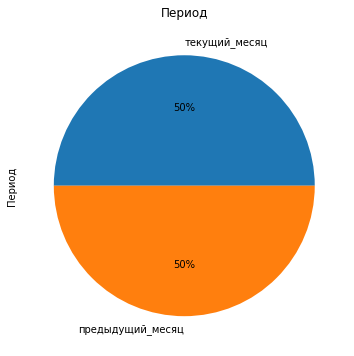

In [32]:
barplotter(df3)

минут анализ


count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

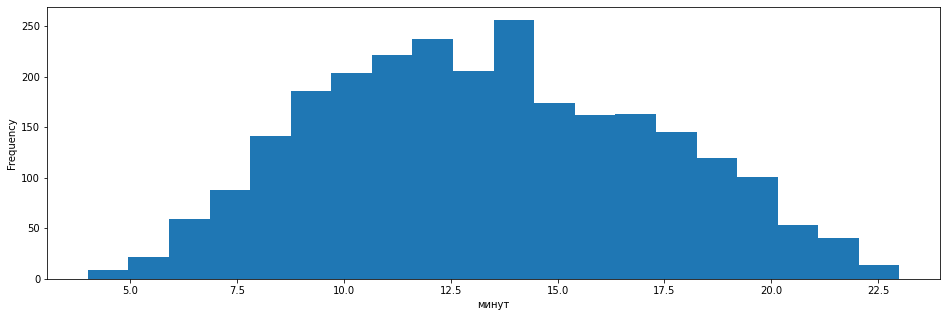

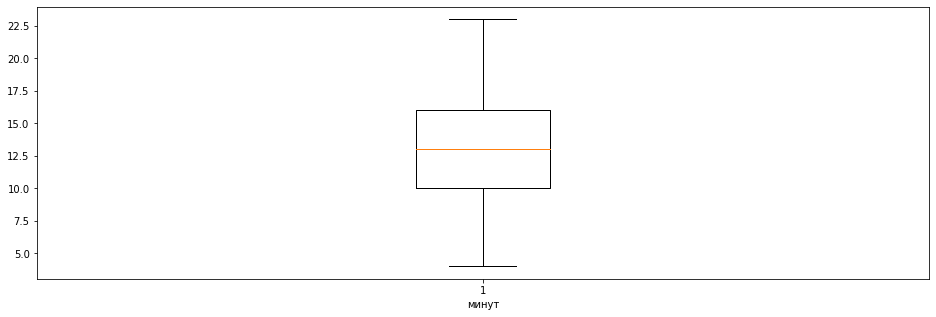

In [33]:
histplotter(df3)

### Выводы по df3
Отсутствуют данные по времени за препредыдущий месяц. Распределение имеющихся данных близкое к нормальному.

### Анализ df4

Прибыль анализ


count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

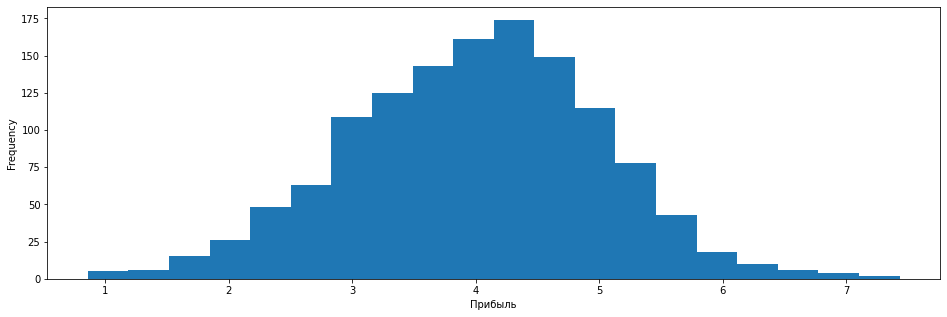

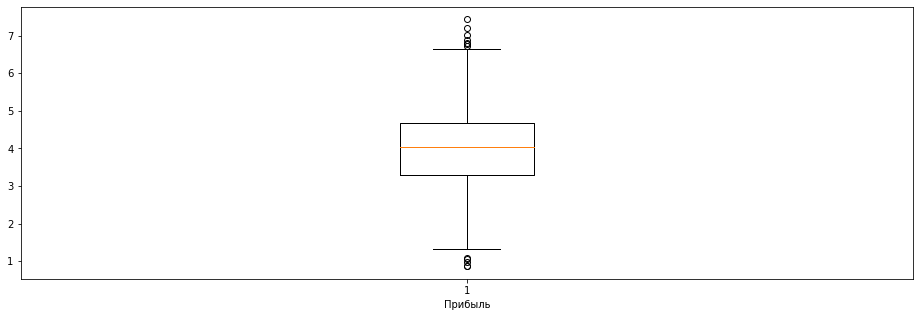

In [34]:
histplotter(df4)

### Выводы по df4
В данных не обнаружено аномалий. Распределение прибыли близко к нормальному.

### Поиск клиентов с покупательской активностью менее трёх месяцев

In [35]:
print('Клиенты с отсутствием покупательской активности в один из последних 3 месяцев')
display(df2[df2['Выручка'] == 0])

del_list = df2[df2['Выручка'] == 0]['id']

df2 = df2[~df2['id'].isin(del_list)]

Клиенты с отсутствием покупательской активности в один из последних 3 месяцев


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Исследован датасет df2, который содержит данные о выручке от каждого из пользователей за последние 3 месяца. Были обнаружены и удалены из датасета несколько клиентов с отсутствием активности в один из 3 последних месяцев. Распределение данных похоже на нормальное.

## Объединение таблиц

In [36]:
# Создание датасета с отдельными столбиками по выручке и минутам по периодам

df20 = pd.DataFrame()
df20['id'] = df2['id']
df20 = df20.drop_duplicates()

df20 = df20.merge(df2[df2['Период'] == 'текущий_месяц'], on = 'id', how = 'left').drop('Период', axis = 1)
df20 = df20.merge(df2[df2['Период'] == 'предыдущий_месяц'], on = 'id', how = 'left').drop('Период', axis = 1)
df20 = df20.merge(df2[df2['Период'] == 'препредыдущий_месяц'], on = 'id', how = 'left').drop('Период', axis = 1)

df20 = df20.merge(df3[df3['Период'] == 'текущий_месяц'], on = 'id', how = 'inner').drop('Период', axis = 1)
df20 = df20.merge(df3[df3['Период'] == 'предыдущий_месяц'], on = 'id', how = 'inner').drop('Период', axis = 1)

df20.columns = ['id', 'Выручка_текущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'минут_текущий_месяц', 'минут_предыдущий_месяц']

df20.sample(10)

,id,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
0,215349,4971.6,5216.0,4472.0,10,12
1,215350,5058.4,5457.5,4826.0,13,8
2,215351,6610.4,6158.0,4793.0,13,11
3,215352,5872.5,5807.5,4594.0,11,8
4,215353,5388.5,4738.5,5124.0,10,10
...,...,...,...,...,...,...
1291,216643,4741.7,3664.0,4704.0,7,14
1292,216644,5353.0,4729.0,5299.0,11,12
1293,216645,5139.2,5160.0,5334.0,18,12
1294,216646,5224.6,4923.0,4725.0,7,18


In [37]:
df_united = df1.merge(df20, on = 'id', how = 'inner')
df_united.sample(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4741.7,3664.0,4704.0,7,14
1292,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5353.0,4729.0,5299.0,11,12
1293,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5139.2,5160.0,5334.0,18,12
1294,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,5224.6,4923.0,4725.0,7,18


### Выводы
Таблицы объединены в один датафрейм. Созданы отдельные столбцы для Минут и Выручки по месяцам. 

## Корреляционный анализ

<module 'seaborn' from '/opt/conda/lib/python3.9/site-packages/seaborn/__init__.py'>

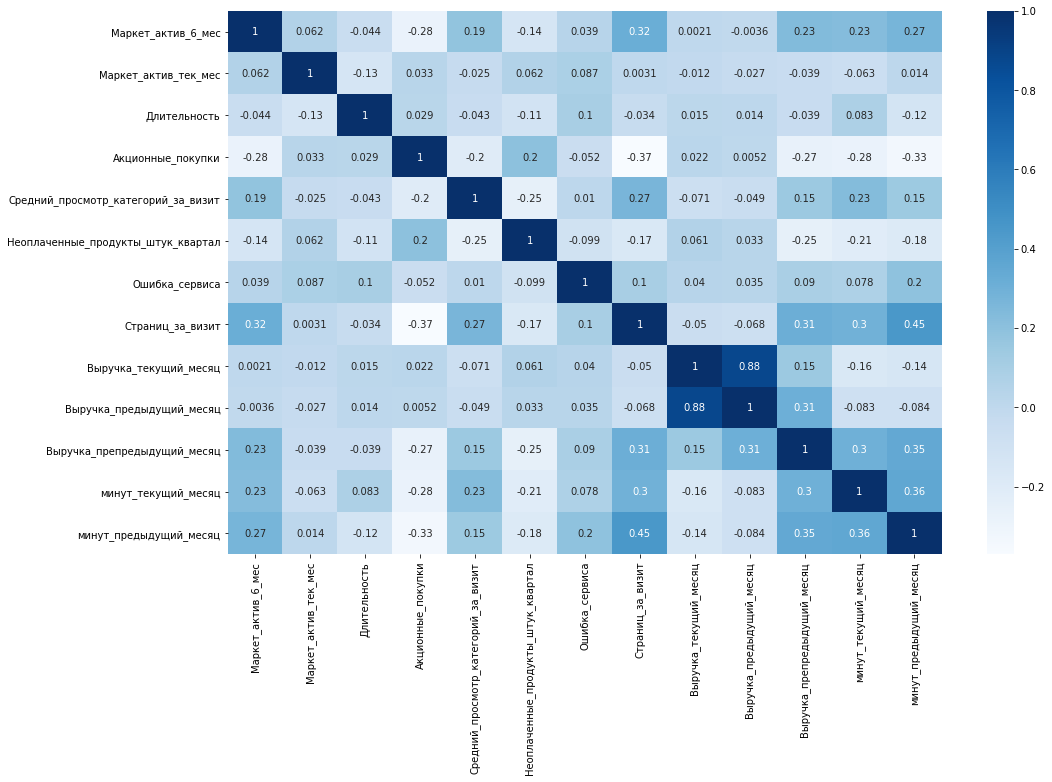

In [38]:
plt.figure(figsize = (16,10))
corr = df_united.drop('id', axis = 1).corr(method = 'spearman')


sns.heatmap(corr, cmap="Blues", annot=True)
sns

### Выводы
В ходе корреляционного анализа не выявлены случаи мультиколлинеарности - коэфициенты корреляции численных признаков не превышают значения 0.9.

## Использование пайплайнов

In [39]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Загружаем данные
df_full = df_united

X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(['Покупательская активность'], axis=1),
    df_full['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_full['Покупательская активность'])

X_train.shape, X_test.shape

X_train_id = X_train
X_train = X_train.drop(['id'], axis=1)
X_test_id = X_test
X_test = X_test.drop(['id'], axis=1)


# Создаём списки с названиями признаков
num_columns = X_train.select_dtypes(exclude=[object]).columns.tolist()
ohe_columns = X_train.drop(num_columns, axis = 1).columns.tolist()


# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# OHE
ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(sparse=False))
    ]
    )

# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # Словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # Словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # Словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # Словарь для модели SVC()    
    {
        'models': [SVC(
            probability=True,
            random_state=RANDOM_STATE 
        )],
        'models__C': range(1,4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмот

0.9160296080572747


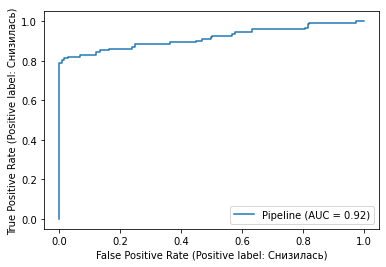

In [40]:
# Построим ROC curve
print(roc_auc_score(y_test, randomized_search.best_estimator_.predict_proba(X_test)[:, 1]))
plot_roc_curve(randomized_search.best_estimator_, X_test, y_test);

### Выводы

При помощи пайплайнов были подготовлены данные численного и категориального типа и найдена лучшая модель.

По результатам оптимизации лучше всего проявила себя модель LogisticRegression с StrandardScaler и параметром резуляризации С = 4. Оптимизация проводилась по метрике roc_auc_score, которая позволяет оценивать работу модели бинарной классификации, для которой важно верное предсказание обоих классов, чем не обладает, например, метрика accuracy. 

Лучшая модель продемонстрировала roc_auc_score = 0.92 на тестовой выборке.

## Анализ важности признаков

In [41]:
# Лучшая модель

best_model = randomized_search.best_estimator_.named_steps['models']
best_model

LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')

In [42]:
# Подготовка данных для shap анализа

x_Train = randomized_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
x_Test = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)


  0%|          | 0/324 [00:00<?, ?it/s]

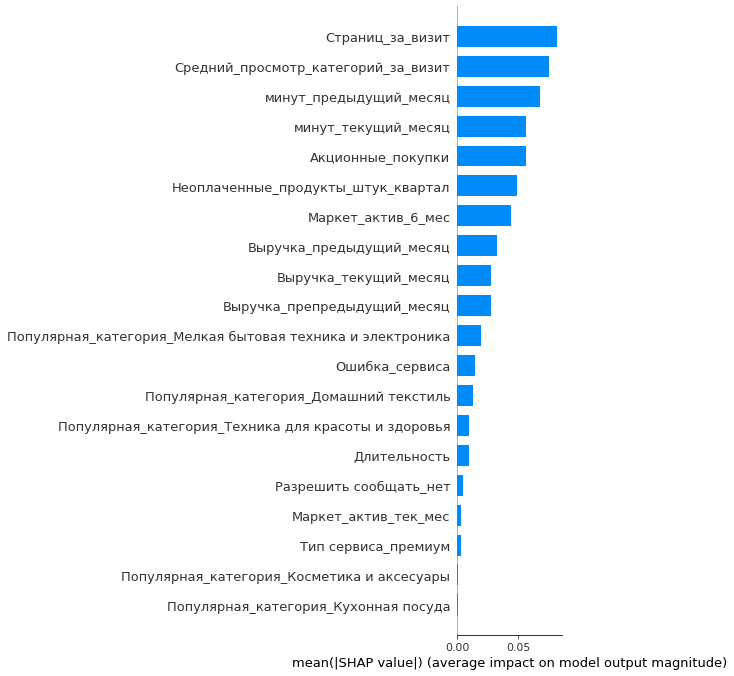

In [43]:
# Shap анализ

K = 50
X_train_summary = shap.sample(x_Train, K)

explainer = shap.KernelExplainer(randomized_search.best_estimator_.named_steps['models'].predict_proba, X_train_summary)
shap_values = explainer(x_Test)

col_names=randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1]['ohe'].get_feature_names(ohe_columns).tolist()+ num_columns
shap_values.feature_names = col_names

# Общий barplot
shap.summary_plot(shap_values[:,:,1], x_Test, plot_type = 'bar')

### Выводы

При помощи SHAP анализа выявлены важные и не важные признаки для лучшей модели.

5 признаков с наибольшим влиянием на результаты: 
- Количество просмотренных страниц за визит
- Количество минут активности за текущий месяц
- Процент акционных покупок
- Количество минут активности за предыдущий месяц
- Просмотр категорий за визит

5 признаков с наименьшим влиянием на результаты: 
- Популярная категория кухонная посуда
- Популярная категория косметика
- Тип сервиса премиум
- Маркетинговая активность текущий месяц
- Разрешить сообщать - нет


При совершении шагов по коррекции можно уделить большее внимание изменению наиболее важных признаков и меньшее внимание наименее важным признакам, например: 
- категория сервиса премиум/стандарт не влияет на снижение активности и нет большого смысла пытаться увеличить сегмент премиум
- покупатели косметики и кухонной посуды в меньшей степени подвержены снижению активности
- имеет смысл повлиять на количество просмотров страниц и категорий за визит, процент акционных покупок и повлиять на количество времени активности клиента 

## Сегментация покупателей

In [44]:
# Создаем датасет с данными о вероятностях снижения активности, данными прибыли и входными данными модели
X_test['proba'] = randomized_search.best_estimator_.predict_proba(X_test_id.drop('id', axis = 1))[:, 1]
X_test['id'] = X_test_id['id']
X_test2 = X_test.merge(df4, on = 'id', how = 'inner').drop('id', axis = 1)
X_test2



,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,proba,Прибыль
0,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3289.2,3973.0,4912.0,17,16,0.012994,4.69
1,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,4170.7,3548.0,4656.0,9,11,0.988978,2.75
2,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,6335.8,5444.0,4565.0,11,20,0.103026,3.16
3,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6758.7,6604.0,4993.0,9,9,0.829038,3.74
4,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5773.8,5090.0,4451.0,18,15,0.505866,4.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4,4158.6,3662.0,4488.0,10,11,0.969516,3.71
320,премиум,да,3.9,4,1048,0.21,Техника для красоты и здоровья,3,0,6,14,4257.4,4325.0,4553.0,17,15,0.046609,4.62
321,стандарт,да,2.4,4,952,0.30,Техника для красоты и здоровья,3,5,2,3,3343.9,3067.0,4165.0,14,13,0.891883,4.07
322,стандарт,нет,4.0,4,748,0.28,Косметика и аксесуары,4,0,4,9,6462.6,5660.5,4885.0,10,14,0.171897,1.97


Text(0.5, 0, 'proba')

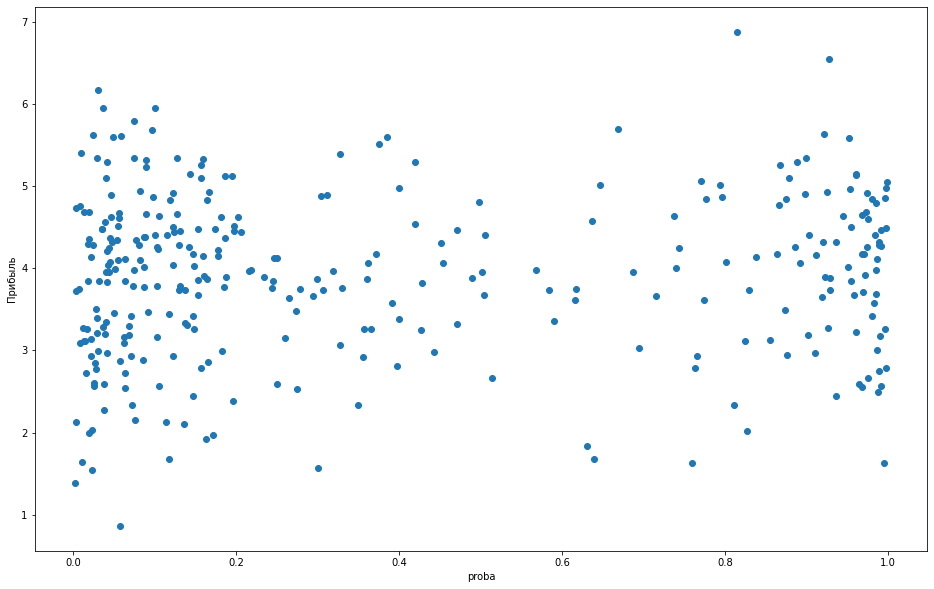

In [45]:
# График рассеяния Вероятность снижения активности vs Прибыль
plt.figure(figsize=(16, 10))
plt.scatter(x = X_test2['proba'], y = X_test2['Прибыль'])
plt.ylabel('Прибыль')
plt.xlabel('proba')

In [46]:
X_filtered = X_test2[(X_test2['proba'] > 0.85)&(X_test2['Прибыль'] > 4)]
print('Количество клиентов в выбранном сегменте - прибыльные с высокой вероятностью снижения:',len(X_filtered))
X_defiltered = X_test2[(X_test2['proba'] <= 0.25)&(X_test2['Прибыль'] > 4)]
print('Количество клиентов в выбранном сегменте - прибыльные с низкой вероятностью снижения:',len(X_defiltered))

Количество клиентов в выбранном сегменте - прибыльные с высокой вероятностью снижения: 43
Количество клиентов в выбранном сегменте - прибыльные с низкой вероятностью снижения: 86


Проанализировав График рассеяния Вероятность снижения активности vs Прибыль решено уделить внимание тем клиентами, у кого proba >0.85 (их вероятность ухода достаточно высока) и у кого прибыль больше 4. Это значимая группа с высокой вероятностью снижения активностью и относительно высокой прибылью. Будем сравнивать их с такими же прибыльными клиентами (Прибыль >4), но с низкой вероятностью снижения активности (<=0.25).

Анализ важных признаков для выбранного сегмента пользователей

Страниц_за_визит анализ сегмента


count    43.000000
mean      3.767442
std       1.555898
min       1.000000
25%       2.500000
50%       4.000000
75%       5.000000
max       8.000000
Name: Страниц_за_визит, dtype: float64


Страниц_за_визит анализ прочих


count    86.000000
mean     10.302326
std       3.508208
min       4.000000
25%       8.000000
50%      10.000000
75%      12.000000
max      20.000000
Name: Страниц_за_визит, dtype: float64

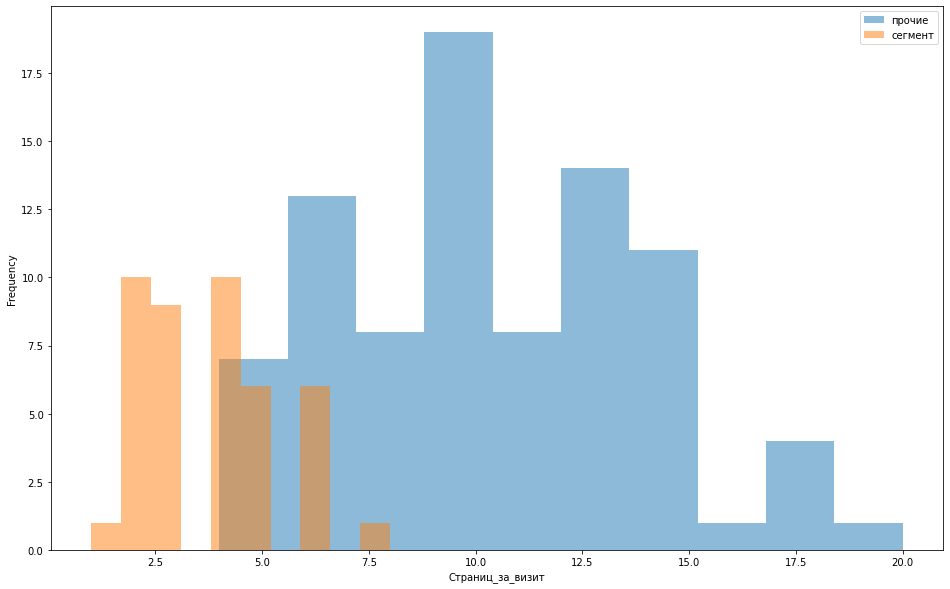

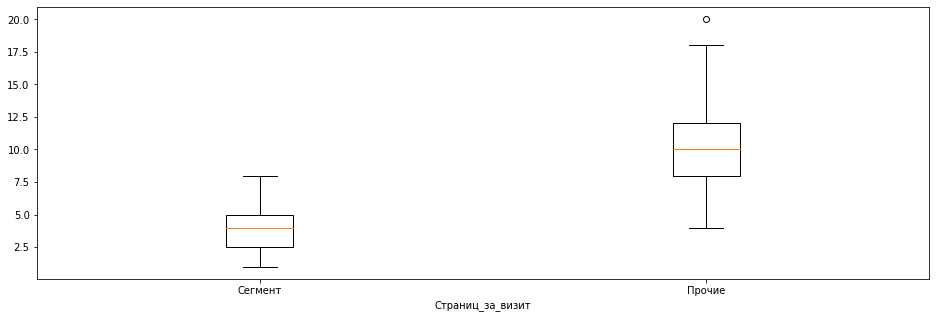

минут_текущий_месяц анализ сегмента


count    43.000000
mean      9.604651
std       2.341545
min       5.000000
25%       8.000000
50%      10.000000
75%      11.000000
max      14.000000
Name: минут_текущий_месяц, dtype: float64


минут_текущий_месяц анализ прочих


count    86.000000
mean     15.186047
std       3.638072
min       7.000000
25%      13.000000
50%      16.000000
75%      18.000000
max      23.000000
Name: минут_текущий_месяц, dtype: float64

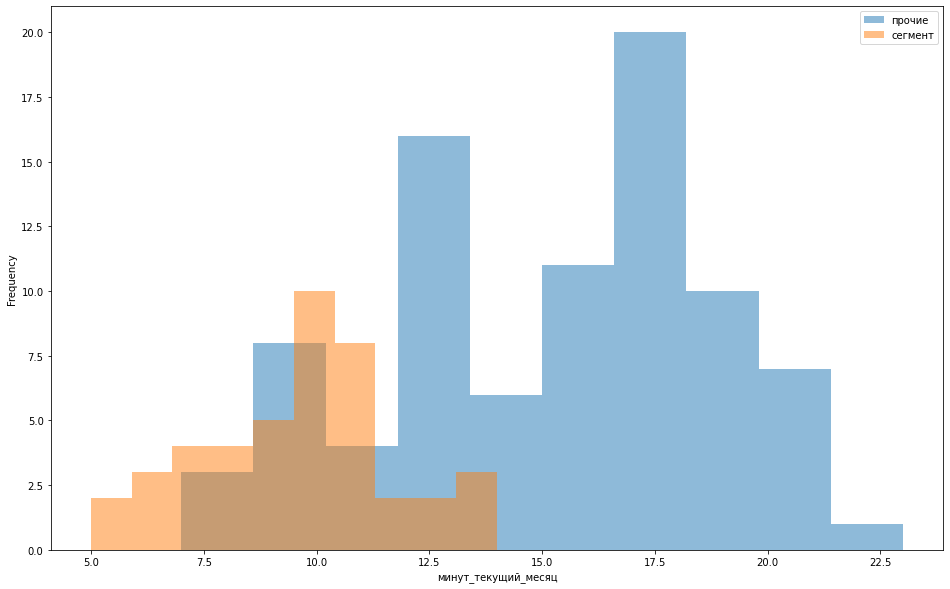

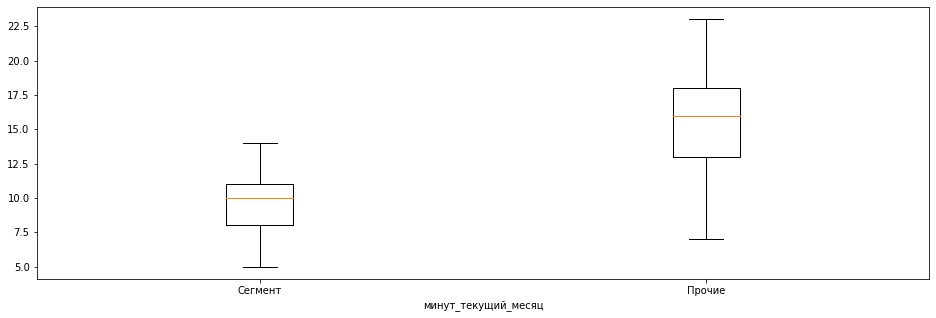

Акционные_покупки анализ сегмента


count    43.000000
mean      0.561163
std       0.330333
min       0.120000
25%       0.285000
50%       0.390000
75%       0.930000
max       0.990000
Name: Акционные_покупки, dtype: float64


Акционные_покупки анализ прочих


count    86.000000
mean      0.219419
std       0.128716
min       0.110000
25%       0.140000
50%       0.200000
75%       0.250000
max       0.940000
Name: Акционные_покупки, dtype: float64

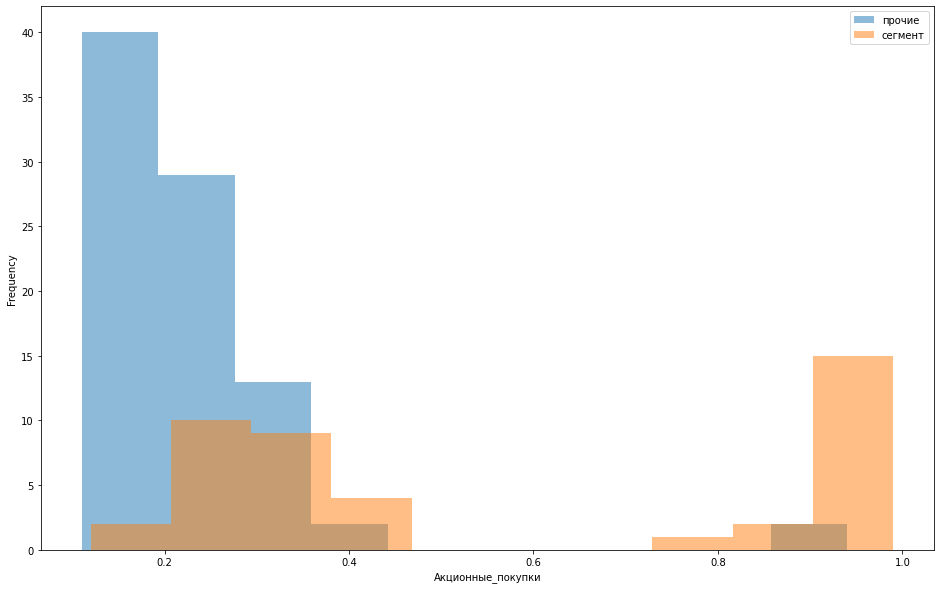

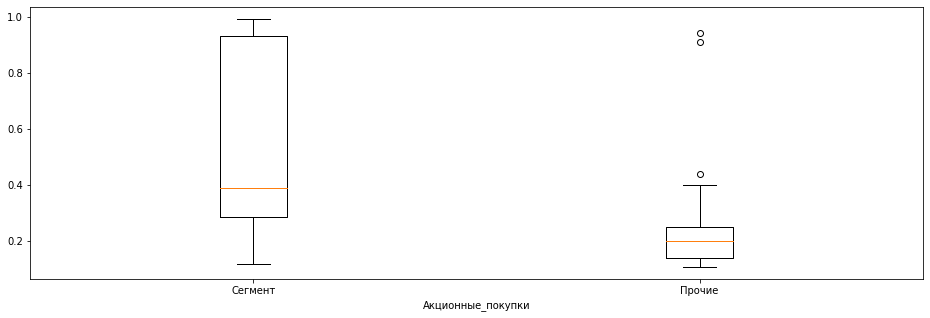

минут_предыдущий_месяц анализ сегмента


count    43.000000
mean      9.348837
std       2.524958
min       5.000000
25%       8.000000
50%      10.000000
75%      11.000000
max      14.000000
Name: минут_предыдущий_месяц, dtype: float64


минут_предыдущий_месяц анализ прочих


count    86.000000
mean     15.104651
std       3.079454
min       7.000000
25%      13.000000
50%      15.000000
75%      17.000000
max      21.000000
Name: минут_предыдущий_месяц, dtype: float64

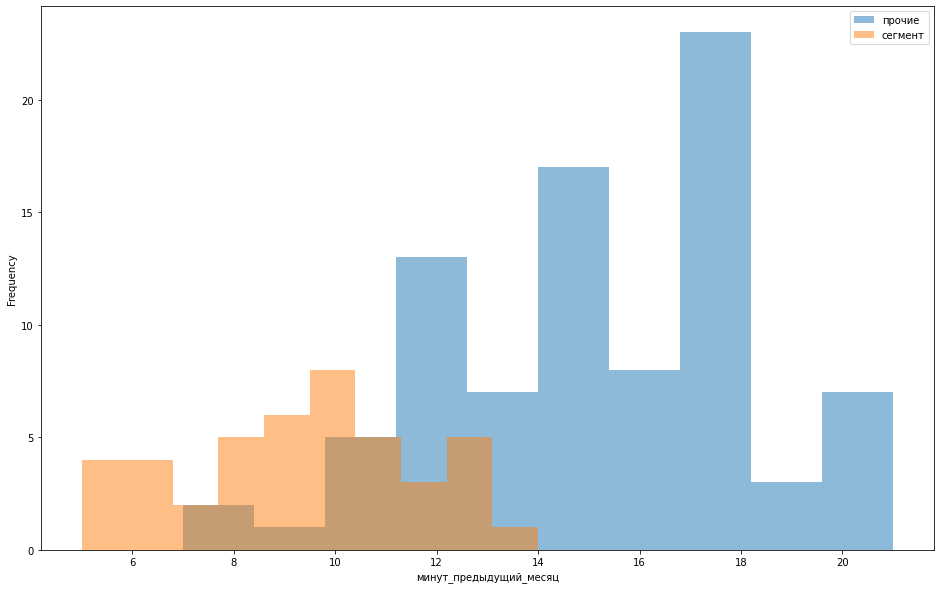

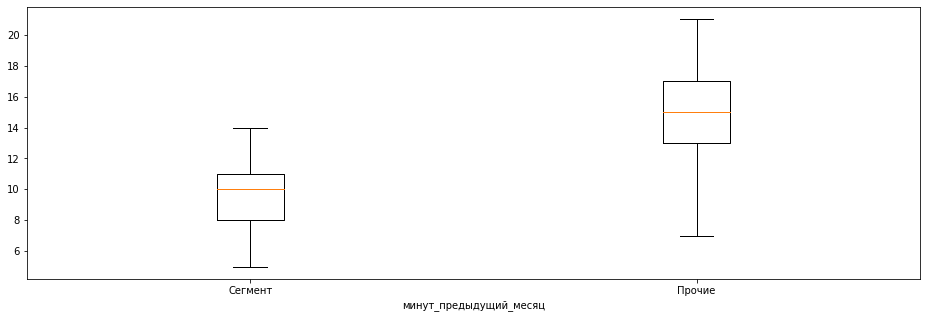

Средний_просмотр_категорий_за_визит анализ сегмента


count    43.000000
mean      2.395349
std       0.903420
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: Средний_просмотр_категорий_за_визит, dtype: float64


Средний_просмотр_категорий_за_визит анализ прочих


count    86.000000
mean      3.825581
std       1.247981
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       6.000000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

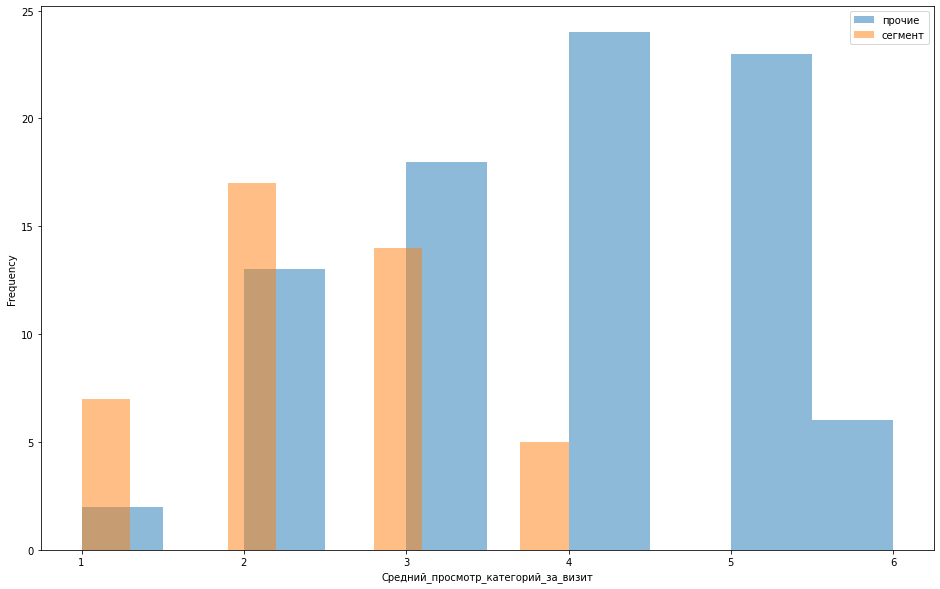

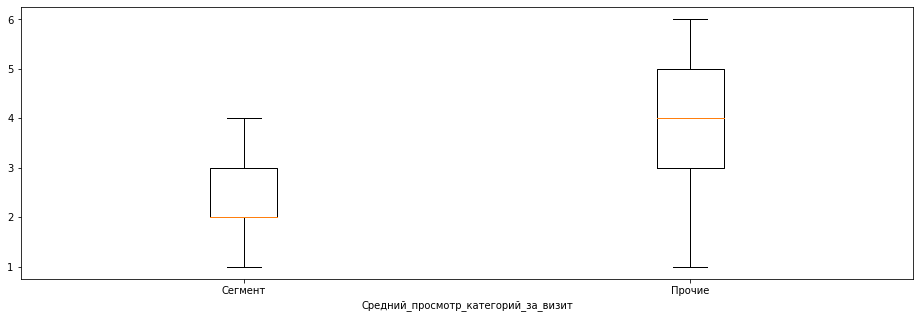

In [47]:
# Список важных параметров модели
important_list = ['Страниц_за_визит', 'минут_текущий_месяц', 'Акционные_покупки', 'минут_предыдущий_месяц', 'Средний_просмотр_категорий_за_визит']

print('Анализ важных признаков для выбранного сегмента пользователей')
print()
for column in important_list:
    print(column, 'анализ сегмента')
    display(X_filtered[column].describe())
    print()
    print(column, 'анализ прочих')
    display(X_defiltered[column].describe())
    print()
    plt.figure(figsize=(16, 10))
    plt.hist(x = X_defiltered[column], alpha = 0.5)
    plt.hist(x = X_filtered[column], alpha = 0.5)
    plt.legend(['прочие', 'сегмент'])
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
    plt.figure(figsize=(16, 5))
    plt.boxplot([X_filtered[column], X_defiltered[column]], labels = ['Сегмент', 'Прочие'])
    plt.xlabel(column)
    plt.show()



Анализ прочих признаков для выбранного сегмента пользователей

Маркет_актив_6_мес анализ сегмента


count    43.000000
mean      3.309302
std       1.067443
min       0.900000
25%       2.400000
50%       3.500000
75%       4.050000
max       5.600000
Name: Маркет_актив_6_мес, dtype: float64


Маркет_актив_6_мес анализ прочих


count    86.000000
mean      4.579070
std       0.696903
min       3.000000
25%       4.100000
50%       4.400000
75%       5.100000
max       6.300000
Name: Маркет_актив_6_мес, dtype: float64

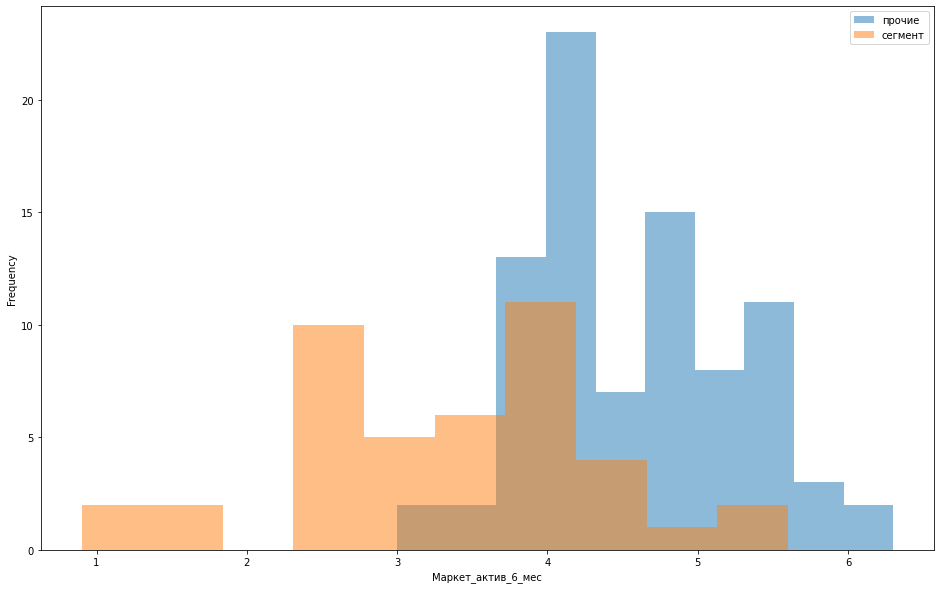

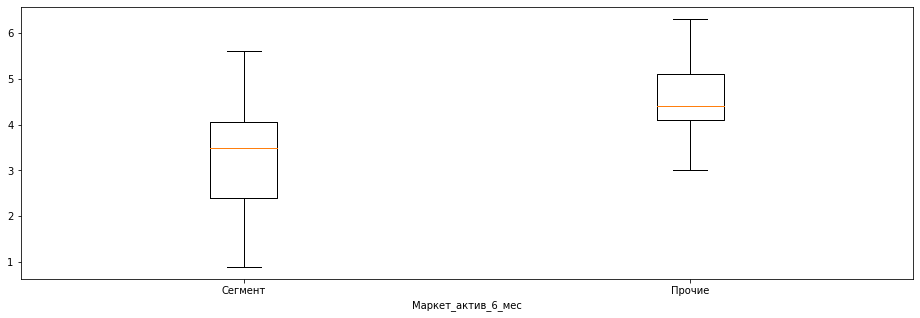

Маркет_актив_тек_мес анализ сегмента


count    43.000000
mean      3.976744
std       0.635774
min       3.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: Маркет_актив_тек_мес, dtype: float64


Маркет_актив_тек_мес анализ прочих


count    86.000000
mean      3.988372
std       0.622976
min       3.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: Маркет_актив_тек_мес, dtype: float64

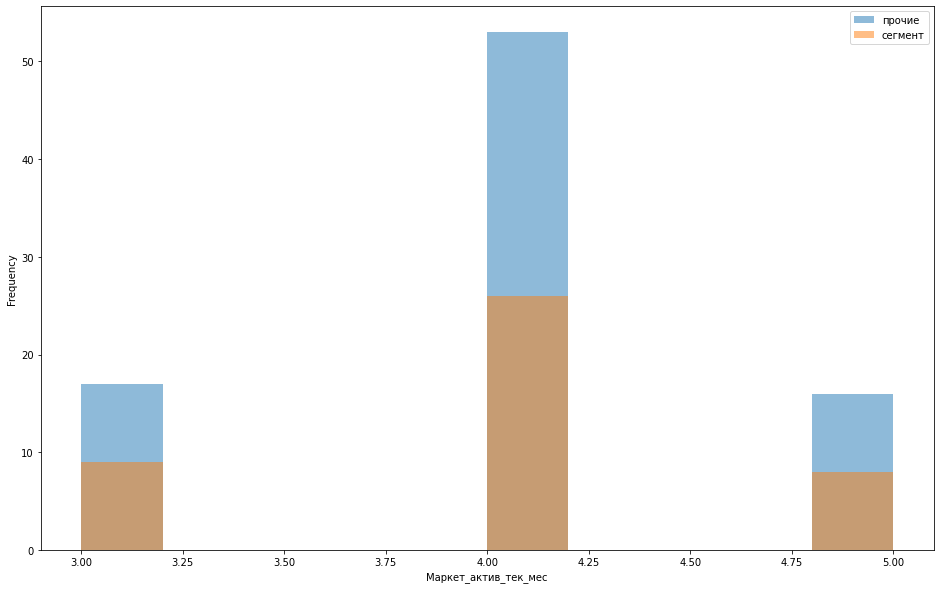

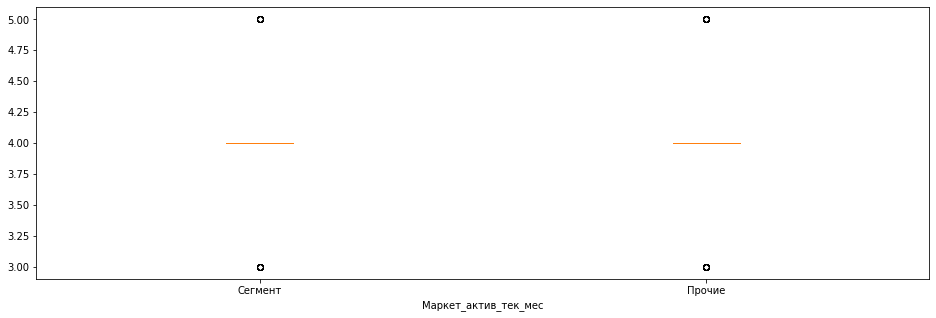

Длительность анализ сегмента


count     43.000000
mean     576.046512
std      233.539734
min      186.000000
25%      409.500000
50%      602.000000
75%      754.500000
max      954.000000
Name: Длительность, dtype: float64


Длительность анализ прочих


count      86.000000
mean      587.313953
std       252.869753
min       129.000000
25%       408.500000
50%       582.000000
75%       779.250000
max      1048.000000
Name: Длительность, dtype: float64

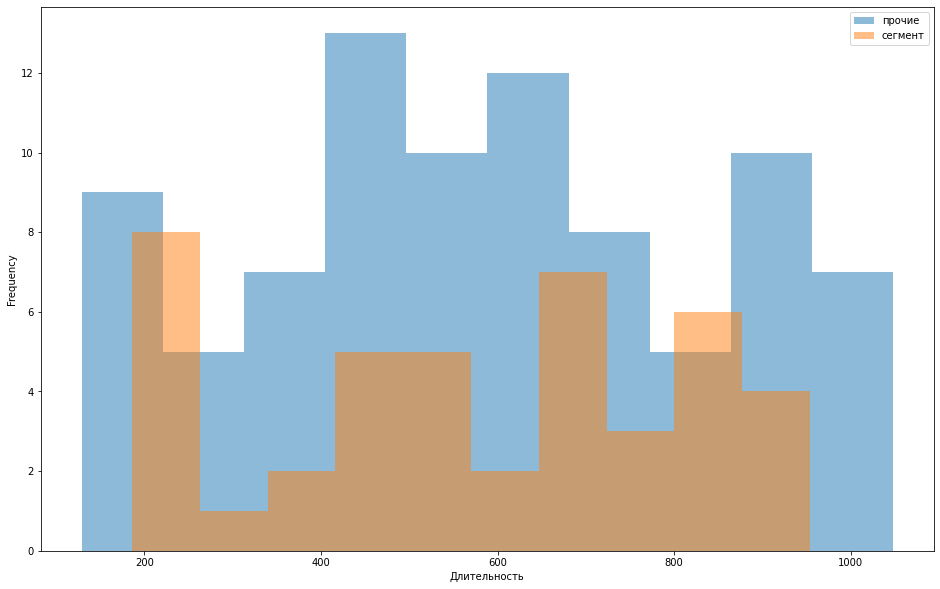

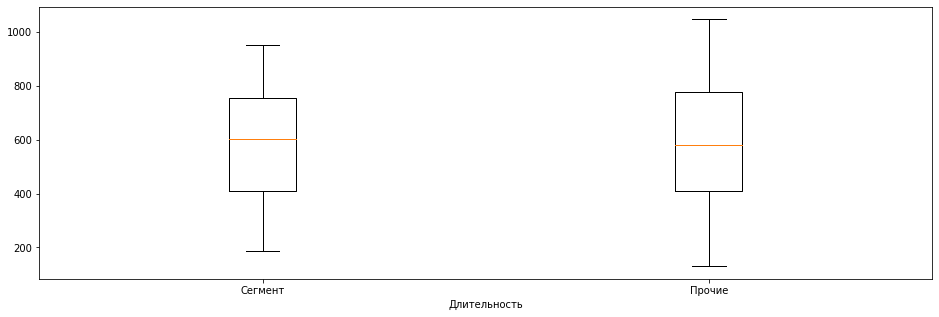

Неоплаченные_продукты_штук_квартал анализ сегмента


count    43.000000
mean      4.395349
std       2.025310
min       1.000000
25%       2.500000
50%       5.000000
75%       6.000000
max       9.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64


Неоплаченные_продукты_штук_квартал анализ прочих


count    86.000000
mean      2.220930
std       1.521618
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

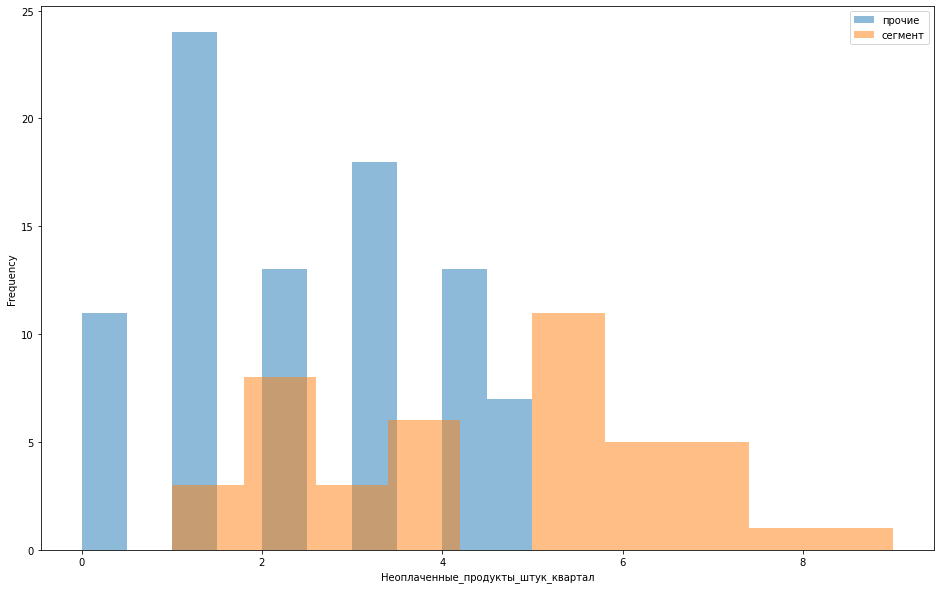

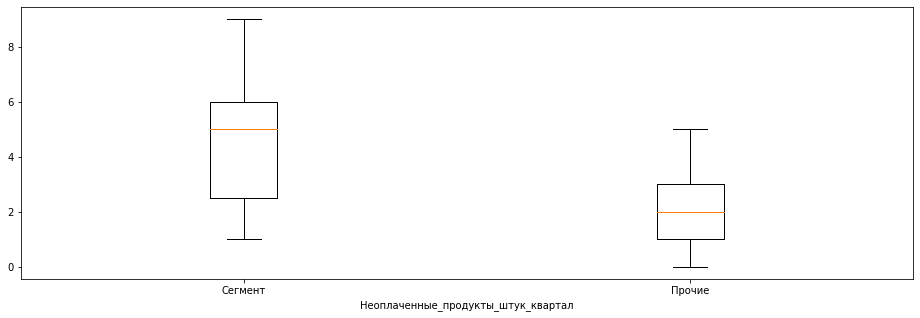

Ошибка_сервиса анализ сегмента


count    43.000000
mean      3.813953
std       1.802852
min       1.000000
25%       2.500000
50%       3.000000
75%       5.000000
max       8.000000
Name: Ошибка_сервиса, dtype: float64


Ошибка_сервиса анализ прочих


count    86.000000
mean      4.616279
std       1.835395
min       0.000000
25%       3.000000
50%       5.000000
75%       6.000000
max       9.000000
Name: Ошибка_сервиса, dtype: float64

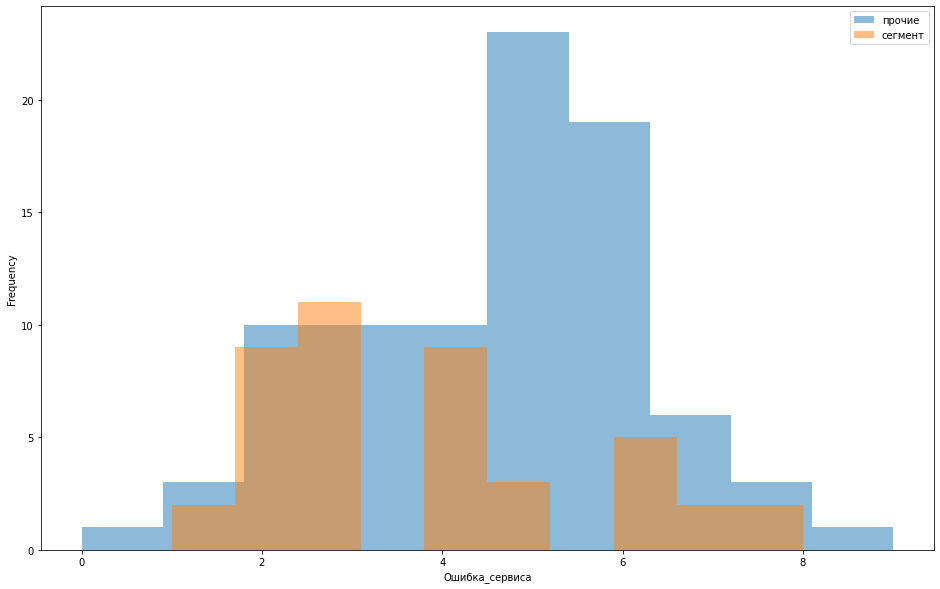

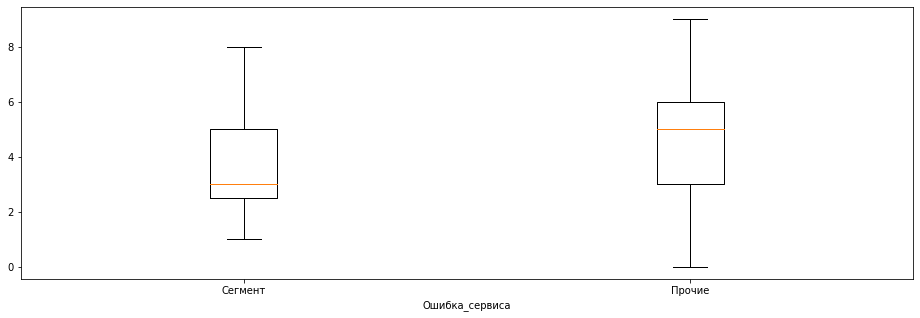

Выручка_текущий_месяц анализ сегмента


count      43.000000
mean     5293.920930
std       880.365211
min      3078.300000
25%      4887.100000
50%      5335.000000
75%      5984.800000
max      7063.000000
Name: Выручка_текущий_месяц, dtype: float64


Выручка_текущий_месяц анализ прочих


count      86.000000
mean     5062.027907
std       742.289941
min      3289.200000
25%      4722.050000
50%      5086.100000
75%      5552.500000
max      6853.400000
Name: Выручка_текущий_месяц, dtype: float64

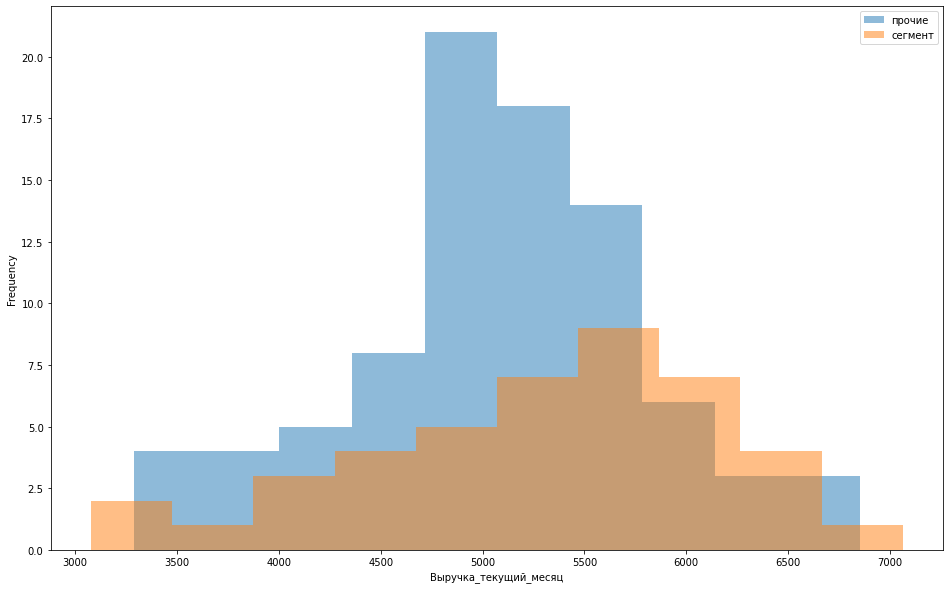

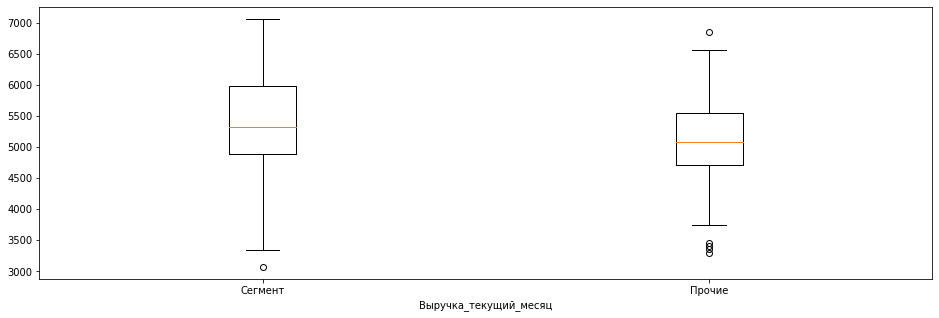

Выручка_предыдущий_месяц анализ сегмента


count      43.000000
mean     5061.220930
std       792.563512
min      2960.000000
25%      4671.250000
50%      5065.500000
75%      5635.250000
max      6291.500000
Name: Выручка_предыдущий_месяц, dtype: float64


Выручка_предыдущий_месяц анализ прочих


count      86.000000
mean     4794.877907
std       612.056773
min      3155.000000
25%      4397.750000
50%      4918.500000
75%      5231.500000
max      5874.000000
Name: Выручка_предыдущий_месяц, dtype: float64

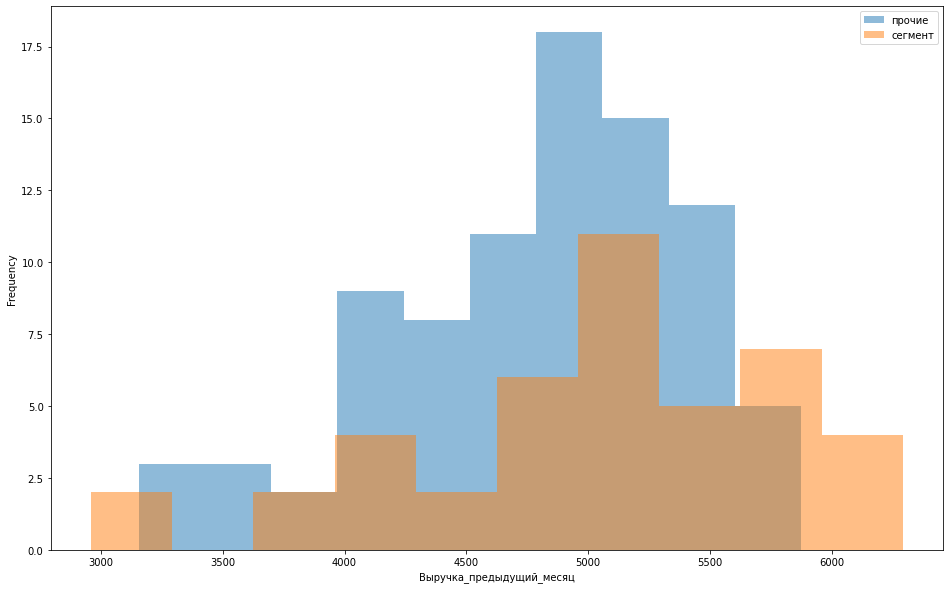

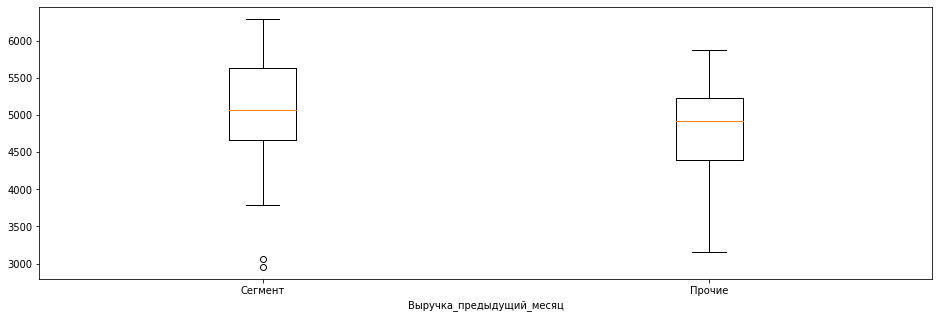

Выручка_препредыдущий_месяц анализ сегмента


count      43.000000
mean     4615.023256
std       228.767972
min      4138.000000
25%      4471.000000
50%      4662.000000
75%      4742.500000
max      4990.000000
Name: Выручка_препредыдущий_месяц, dtype: float64


Выручка_препредыдущий_месяц анализ прочих


count      86.000000
mean     4911.162791
std       296.964995
min      4357.000000
25%      4714.500000
50%      4916.500000
75%      5114.750000
max      5624.000000
Name: Выручка_препредыдущий_месяц, dtype: float64

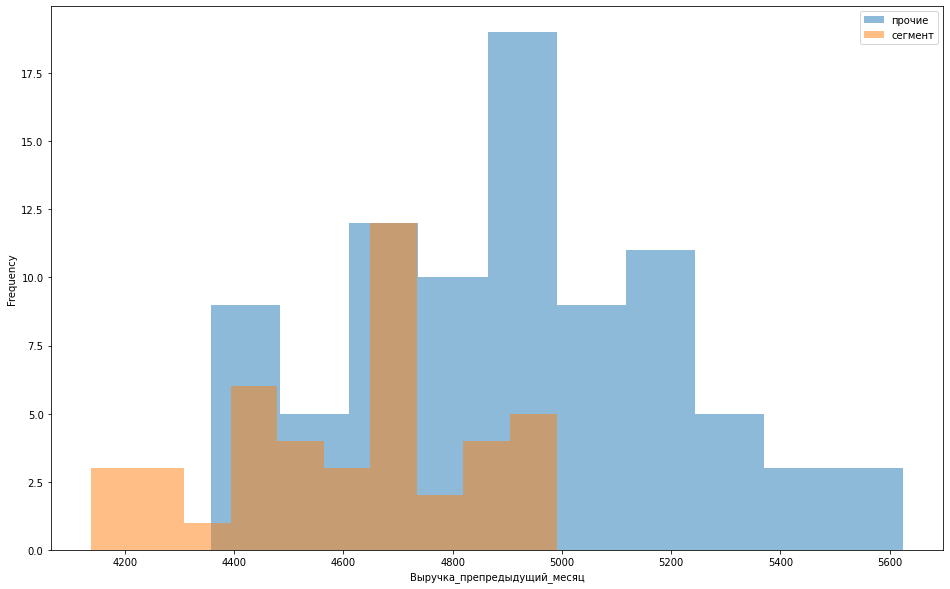

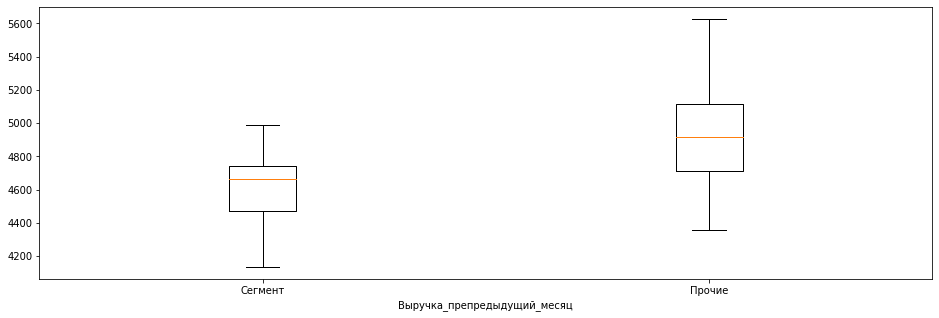

Тип сервиса анализ сегмента


count           43
unique           2
top       стандарт
freq            28
Name: Тип сервиса, dtype: object


Тип сервиса анализ прочих


count           86
unique           2
top       стандарт
freq            62
Name: Тип сервиса, dtype: object

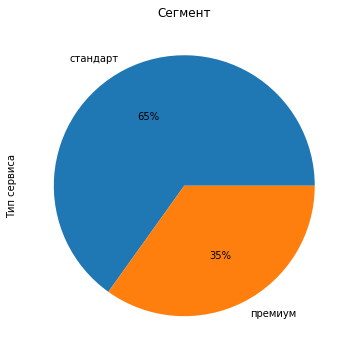

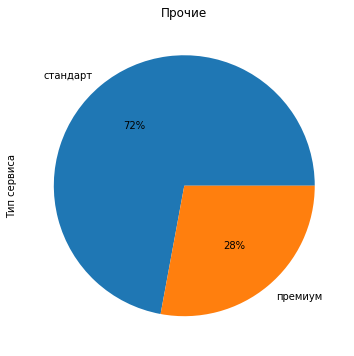

Разрешить сообщать анализ сегмента


count     43
unique     2
top       да
freq      32
Name: Разрешить сообщать, dtype: object


Разрешить сообщать анализ прочих


count     86
unique     2
top       да
freq      65
Name: Разрешить сообщать, dtype: object

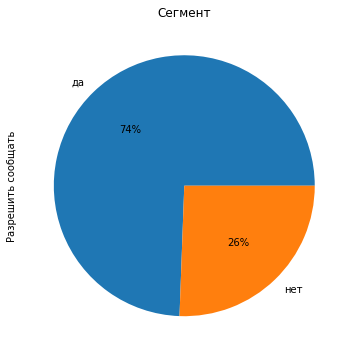

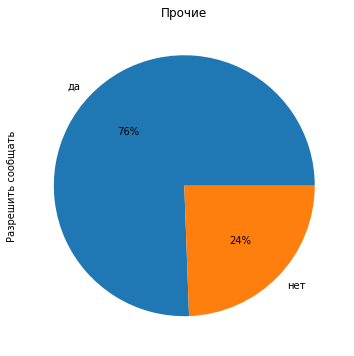

Популярная_категория анализ сегмента


count                   43
unique                   6
top       Товары для детей
freq                    12
Name: Популярная_категория, dtype: object


Популярная_категория анализ прочих


count                        86
unique                        6
top       Косметика и аксесуары
freq                         17
Name: Популярная_категория, dtype: object

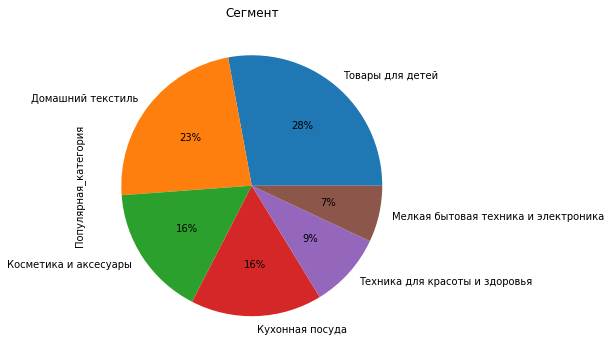

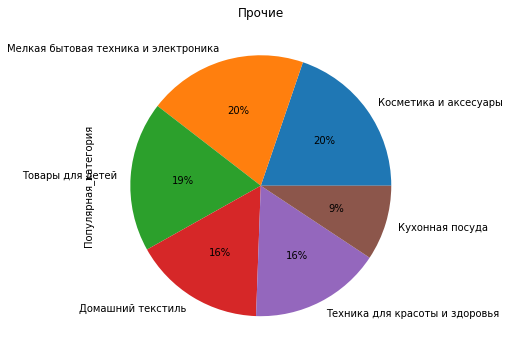

In [48]:
print('Анализ прочих признаков для выбранного сегмента пользователей')
print()   

    
for column in X_filtered.drop(important_list, axis = 1).drop(['proba', 'Прибыль'], axis = 1).select_dtypes(exclude=[object]).columns:
    print(column, 'анализ сегмента')
    display(X_filtered[column].describe())
    print()
    print(column, 'анализ прочих')
    display(X_defiltered[column].describe())
    print()
    plt.figure(figsize=(16, 10))
    plt.hist(x = X_defiltered[column], alpha = 0.5)
    plt.hist(x = X_filtered[column], alpha = 0.5)
    plt.legend(['прочие', 'сегмент'])
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
    plt.figure(figsize=(16, 5))
    plt.boxplot([X_filtered[column], X_defiltered[column]], labels = ['Сегмент', 'Прочие'])
    plt.xlabel(column)
    plt.show()
    
for column in X_filtered.drop(important_list, axis = 1).drop(['proba', 'Прибыль'], axis = 1).select_dtypes(include=[object]).columns:
    print(column, 'анализ сегмента')
    display(X_filtered[column].describe())
    print()
    print(column, 'анализ прочих')
    display(X_defiltered[column].describe())
    print()
    plt.figure(figsize=(16, 10))
    X_filtered[column].value_counts(dropna=False).plot(kind="pie", autopct='%1.0f%%', figsize=(11, 6), title = 'Сегмент')
    plt.show()
    plt.figure(figsize=(16, 10))
    X_defiltered[column].value_counts(dropna=False).plot(kind="pie", autopct='%1.0f%%', figsize=(11, 6), title = 'Прочие')
    plt.show()

### Выводы

Соотнося данные выше, можно сделать следующие предположения о выбранном сегменте клиентов: 
- это лояльные сервису клиенты (от полугода до нескольких лет с момента регистрации), значительная доля из них (30%) пользуется премиумом и большинство желает получать дополнительные оповещения о товарах
- большая доля клиентов пользуется исключительно акционными предложениями (90-100%), оставшаяся часть также активно пользуется акциями (30%)
- основные категории - товары для детей и домашний текстиль
- клиенты просматривают мало категорий и страниц и разрешают дополнительные оповещения о товарах, т.е. они приходят за конкретными товарами
- клиенты чаще среднего добавляют товары в корзину и не оплачивают их
- время, проводимое на сайте и выручка плавно увеличиваются в последние месяцы

Проведя сравнение Сегмента с прибыльными клиентами (Прибыль >4) с низкой вероятностью снижения активности (<25%) (Прочие) можно охарактеризовать клиентов Сегмента как любителей акций: 
- они заходят на сайт за конкретными товарами (4 карточки за визит у Сегмента против 10 карточех у Прочих), 
- просматривают только их и их категории (2 категории у Сегмента против 4 категорий у Прочих), 
- добавляют в корзину и не покупают (5 неоплаченных за квартал продукта у Сегмента против 2 у Прочих), 
- проводят на сайте мало времени (10 минут у Сегмента против 15 минут у Прочих),
- находясь в ожидании акции (медиана 39% акционных покупок у Сегмента против 20% у Прочих).

Прогнозируемое падение активности можно попробовать объяснить предшествующей акцией, во время которой пользователи временно закрыли потребности на товары длительного пользования. Их активность вероятно циклична. Клиенты ждут следующей акции.


Для поддержания и увеличения пользовательской активности в этой группе клиентов можно попробовать предпринять следующие меры: 
- Регулярнее проводить акции, в ходе которых зачастую закупается данная группа клиентов. Например, можно предлагать клиентам купоны на следующую покупку со сроком действия до 3 месяцев, стимулируя постоянный спрос. 
- Также можно попробовать активнее предлагать клиенту товары из его целевой категории и пробовать удерживать их на сайте другими способами.



## Общий вывод

В рамках задачи по исследованию аудитории сервиса и стимулированию активности постоянных пользователей интернет-магазина «В один клик» были реализованы следующие этапы: 
1. Получены, предобработаны и изучены входные данные из 4 датасетов: 
    - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении, 
    - данные о выручке, которую получает магазин с покупателя,
    - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода,
    - данные о среднемесячной прибыли покупателя за последние 3 месяца.

Удалось устранить ошибки в данных и провести исследовательский и корреляционный анализы данных (максимальные и минимальные значения, распределения).

2. Построены и использованы пайплайны для подготовки численных и категориальных данных и поиска лучшей модели предсказания снижения активности клиента.

Сравнивались модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC(). Лучшую метрику на тестовой выборке roc_auc_score (0.92) продемострировала модель LogisticRegression с функцией масштабирования данных StandardScaler и параметром резуляризации С = 4. При помощи SHAP анализа выявлены наиболее и наименее важные признаки входных данных для лучшей модели.

3. Для более подробного анализа была выбрана группа клиентов с наибольшей вероятностью снижения активности и наибольшей прибылью (42 клиента). 
    - Изучен характер взаимодействия сегмента с компанией: клиенты долго (от полугода) взаимодействуют с компанией и готовы получать дополнительные уведомления, 30% имеют премиум сервис.
    - Продуктовое поведение сегмента: клиенты приобретают товары для детей, домашний текстиль, косметику и кухонную посуду. Просматривают малое число продуктов. 
    - Покупательское поведение: весь сегмент активно пользуется акциями (до 30% акционных покупок), а значимая часть сегмента совершает покупки только по акциям. Выручка не испытывает больших колебаний, тем не менее плавно растет за последние несколько месяцев.
    - Поведение на сайте: время, проводимое на сайте, не испытывает больших колебаний, тем не менее плавно растет за последние несколько месяцев. Клиенты просматривают малое количество страниц за визит. 
    
Было сделано предположение, что клиенты данного сегмента приобретают небольшую номенклатуру товаров среднего и длительного пользования и предпочитают совершать покупки по акциям. 
Поскольку взаимодействие сегментов с компанией уже достаточно длинное и тесное (многие имеют премиум и согласны получать дополнительные рассылки), для увеличения активности необходимо с большей регулярностью проводить акции на интересующую их узкую номенклатуру товаров. 

Одним из практических вариантов может быть предложение купонов на следующую покупку с ограниченным временем действия. 

Также можно попробовать активнее предлагать клиентам сегмента товары из его целевой категории и пробовать удерживать их на сайте другими способами, поскольку количество минут на сайте и количество просмотренных за визит страниц являются важными входными параметрами.
